# ShearLineCNN
> Shear Line Classification using CNN.

## Revision History

| #   | Date       | Action                                           | Modified by        |
|-----|------------|--------------------------------------------------|--------------------|
|     |            |                                                  |                    |
| 015 | 2025-05-22 | Decrease initial LR                              | rmaniego           |
| 014 | 2025-05-22 | Change to Tversky loss                           | rmaniego           |
| 013 | 2025-05-21 | Add data augmentation                            | rmaniego           |
| 012 | 2025-05-21 | Add data preprocessing                           | rmaniego           |
| 011 | 2025-05-20 | Migrate to U-Net architecture                    | rmaniego           |
| 010 | 2025-05-16 | Optimize architecture                            | rmaniego           |
| 009 | 2025-05-16 | Improve architecture                             | rmaniego           |
| 008 | 2025-05-15 | Fix model metrics                                | rmaniego           |
| 007 | 2025-05-03 | Fix testing evaluation                           | rmaniego           |
| 006 | 2025-05-03 | Fix dataset loader                               | rmaniego           |
| 005 | 2025-05-03 | Fix segmentation dataset                         | rmaniego           |
| 004 | 2025-04-10 | Fix architecture to match dataset                | rmaniego           |
| 003 | 2025-04-10 | Update architecture base codes                   | rmaniego           |
| 002 | 2025-04-09 | Prepare dataset                                  | rmaniego           |
| 001 | 2025-03-29 | Create GitHub repository                         | rmaniego           |

## Step 1. Mount Google Drive

**Notes:**.
 - This requires GDrive permissions.
 - Update changes in local repository.
 - Re-run cell for every commit changes in the repository.
 - Colab is read only, unless set in GitHub FGPATs

```python
pip install jupyterlab
pip install notebook
jupyter notebook
```

**GitHub Personal Access Tokens (PAT)**
1. Go to `https://github.com/settings/tokens`.
2. On the sidebar, select `Fine-grained tokens`.
3. Fill-up appropriate details, limit read/write access.
4. Copy generated `PAT` to local environment variables.
5. Do the same to Google Colab secrets.
6. Once expired, move the old repo in GDrive to trash.

In [4]:
import os

github_fgpat = None
live_on_colab = False
environment_ready = False

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

try:
    from google.colab import drive, userdata

    drive.mount("/content/drive")

    live_on_colab = True
    github_fgpat = userdata.get("ShearLineCNN")
    print("Running on Google Colaboratory...")
except ImportError:
    print("Running locally...")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Running on Google Colaboratory...


## Step 2. Check Colab Compute Engine Backend
**Note:** Execute to verify HW accelerator allocation, use information on manuscript.

HW accelerator availability may vary, so ensure that the session is timed and is connected to expected runtime environment in all iterations. Options include:
1. NVIDIA A100 Tensor Core GPU - high-performance deep learning training (recommended).
2. NVIDIA L4 Tensor Core GPU - optimized for AI inference tasks with high performance and efficiency (preferred during HP fine-tuning).
3. NVIDIA T4 Tensor Core GPU - cost-effective, versatile, and suitable for a variety of tasks.


In [5]:
if live_on_colab:
    gpu_info = !nvidia-smi
    gpu_info = "\n".join(gpu_info)
    if gpu_info.find("failed") >= 0:
        print("Not connected to a GPU")
    else:
        print(gpu_info)

    from psutil import virtual_memory

    ram_gb = virtual_memory().total / 1e9
    print(f"Your runtime has {ram_gb:.1f} gigabytes of available RAM")

    if ram_gb < 20:
        print("Not using a high-RAM runtime")
    else:
        print("You are using a high-RAM runtime!")

Mon May 26 22:02:10 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             45W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

## Step 3. Change Working Directory

**Notes:**  
1. Before continuing, make sure you check your GDrive storage usage; cloning on limited storage may impact contents.  
2. Execute cell to ensure the notebook is running under the latest version of project repository.  

In [6]:
if live_on_colab:
    NB = "/content/drive/MyDrive/Colab Notebooks"
    os.makedirs(NB, exist_ok=True)
    os.chdir(NB)

    def update_repo():

        REPO = f"{NB}/ShearLineCNN2"
        if not os.path.isdir(REPO):
            !git clone https://{github_fgpat}@github.com/rmaniego/ShearLineCNN.git ShearLineCNN2
            os.chdir(REPO)
            return

        os.chdir(REPO)
        !git reset --hard HEAD
        !git pull origin main

    update_repo()

print(os.getcwd())

Updating files: 100% (3129/3129), done.
HEAD is now at e419380 [nb] Fix notebook
From https://github.com/rmaniego/ShearLineCNN
 * branch            main       -> FETCH_HEAD
Already up to date.
/content/drive/MyDrive/Colab Notebooks/ShearLineCNN2


## Step 4. Install Dependencies
**Note:** Execute cell everytime the `Google Colab` runtime environment reconnected.

In [7]:
if live_on_colab:
    %pip install -U jupyterlab
    %pip install -U notebook
    %pip install -U opencv-python
    %pip install -U scikit-learn
    %pip install -U scikit-image
    %pip install -U matplotlib
    %pip install -U seaborn
    %pip install -U tensorflow
    %pip install -U tabulate
print("Environment is ready...")

Environment is ready...


## Step 5: Import the Packages  

import all third party libraries necessary for the ANN model to execute successfully.

In [8]:
import glob
import json
import time
import random
import warnings
from datetime import datetime

warnings.filterwarnings("ignore", category=RuntimeWarning, message="os.fork()")
warnings.filterwarnings("ignore", category=UserWarning, message="Your `PyDataset` class should call")
warnings.filterwarnings("ignore", category=UserWarning, message="warn")

import cv2
import numpy as np
import tensorflow as tf
from skimage.morphology import disk
from scipy.ndimage import binary_dilation
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping  #, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Conv2DTranspose, UpSampling2D, Concatenate, Cropping2D
from tensorflow.keras.optimizers import Adadelta, AdamW, Lion, RMSprop, SGD
from tensorflow.keras.optimizers.schedules import CosineDecayRestarts
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau


gpus = tf.config.list_physical_devices("GPU")

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
            print(e)
    print("GPU detected. Running on GPU.")
else:
    print("No GPU detected. Running on CPU.")

GPU detected. Running on GPU.


## Step 6: Load Datasets  

Load and prepare the training and testing datasets.

In [9]:
def load_features(source, target, category):
    basenames, features, labels = [], [], []

    sources = glob.glob(f"{source}/{category}/*.json")
    for i, source_path in enumerate(sources):
        filename = os.path.basename(source_path)

        with open(source_path, "r", encoding="utf-8") as file:
            data1 = np.array(json.load(file))

        target_path = f"{target}/{category}/{filename}"
        with open(target_path, "r", encoding="utf-8") as file:
            data2 = np.array(json.load(file))

        features.append(data1)
        labels.append(data2)
        basenames.append(filename)

    return basenames, np.array(features), np.array(labels)


#################################################
# Label Dilation (Widening)                     #
#-----------------------------------------------#
# Dilate shear line annotation to help model    #
# converge faster. Since 1px is too thin        #
# for the model to classify easiliy.            #
#################################################

def label_line_widening(labels_array, target_width=5):
    """
    Modifies the line width in a batch of binary segmentation masks in-memory
    to a specified target width using morphological dilation.
    """

    if target_width < 1 or target_width % 2 == 0:
        raise ValueError("target_width must be a positive odd integer (e.g., 1, 3, 5).")

    dilation_radius = (target_width - 1) // 2

    if dilation_radius == 0:
        return labels_array.astype(labels_array.dtype)

    struct_elem = disk(dilation_radius)

    modified_labels = np.zeros_like(labels_array, dtype=labels_array.dtype)
    num_samples = labels_array.shape[0]

    for i in range(num_samples):
        label_2d = labels_array[i].squeeze()

        modified_label_2d = binary_dilation(label_2d, structure=struct_elem).astype(labels_array.dtype)

        if len(labels_array.shape) == 4:
            modified_labels[i] = np.expand_dims(modified_label_2d, axis=-1)
        else:
            modified_labels[i] = modified_label_2d

    return modified_labels


basenames_list, features_list, labels_list = [], [], []

categories = ["no-shear", "shear"]
segmentation_source = "data/segmentation/source"
segmentation_target = "data/segmentation/target"
for category in categories:
    basenames, features, labels = load_features(segmentation_source, segmentation_target, category)
    if features.size > 0:
        basenames_list.extend(basenames)
        features_list.append(features)
        labels_list.append(labels)

features = np.vstack(features_list)
labels = np.vstack(labels_list)
basenames = np.array(basenames_list)

target_width = 3
labels = labels.astype(np.uint8)
labels = label_line_widening(labels, target_width=target_width)


#################################################
# Perturbation-based Dataset Augmentation       #
#################################################

test_ratio = 0.1
target_total_size = 1000
train_val_target_size = int(target_total_size * (1 - test_ratio))

binary_class_labels = np.array([1 if labels[i].any() else 0 for i in range(len(labels))])

# 90:10 split for testing (using indices) with stratification
total_indices = np.arange(len(basenames))
train_val_indices, test_indices = train_test_split(
    total_indices,
    test_size=test_ratio,
    shuffle=True,
    stratify=binary_class_labels
)

features_train_val = features[train_val_indices]
labels_train_val = labels[train_val_indices]
basenames_train_val = basenames[train_val_indices]

"""
current_train_val_size = len(features_train_val)
if current_train_val_size < train_val_target_size:
    num_augmentations_needed = train_val_target_size - current_train_val_size

    augmented_features_list = []
    augmented_labels_list = []
    augmented_basenames_list = []
    noise_std_dev = 0.5

    idx_to_augment = list(range(current_train_val_size))
    random.shuffle(idx_to_augment)

    aug_count = 0
    while aug_count < num_augmentations_needed:
        if not idx_to_augment:
            idx_to_augment = list(range(current_train_val_size))
            random.shuffle(idx_to_augment)

        original_idx = idx_to_augment.pop(0)

        original_feature = features_train_val[original_idx]
        original_label = labels_train_val[original_idx]
        original_basename = basenames_train_val[original_idx]

        noise = np.random.normal(loc=0.0, scale=noise_std_dev, size=original_feature.shape)
        aug_feature = original_feature + noise
        aug_label = original_label

        augmented_features_list.append(aug_feature)
        augmented_labels_list.append(aug_label)
        augmented_basenames_list.append(f"{original_basename}_aug{aug_count}_noise{noise_std_dev}")

        aug_count += 1
        if aug_count % 100 == 0:
            print(f"Generated {aug_count} augmented samples...")

    augmented_features = np.array(augmented_features_list)
    augmented_labels = np.array(augmented_labels_list)
    augmented_basenames = np.array(augmented_basenames_list)

    features_train_val = np.concatenate((features_train_val, augmented_features), axis=0)
    labels_train_val = np.concatenate((labels_train_val, augmented_labels), axis=0)
    basenames_train_val = np.concatenate((basenames_train_val, augmented_basenames), axis=0)
"""


#################################################
# Dataset Splitting                             #
#################################################

train_val_labels = np.array([1 if labels_train_val[i].any() else 0 for i in range(len(labels_train_val))])

# 70:30 split for train-validation (on train-val set) with stratification
train_val_size = len(features_train_val)
indices_train, indices_val = train_test_split(
    np.arange(train_val_size),
    test_size=0.3,
    shuffle=True,
    stratify=train_val_labels
)

features_train = features_train_val[indices_train]
labels_train = labels_train_val[indices_train]
basenames_train = basenames_train_val[indices_train]

features_val = features_train_val[indices_val]
labels_val = labels_train_val[indices_val]
basenames_val = basenames_train_val[indices_val]

features_test = features[test_indices]
labels_test = labels[test_indices]
basenames_test = basenames[test_indices]

n_train = len(features_train)
n_val = len(features_val)
n_test = len(features_test)

print(f"Train samples: {n_train}")
print(f"Validation samples: {n_val}")
print(f"Test samples: {n_test}")

n_dataset = n_train + n_val + n_test
print(f"TOTAL: {n_dataset}")

print("Dataset ready...")

Train samples: 488
Validation samples: 210
Test samples: 78
TOTAL: 776
Dataset ready...


## Step 7: Define the Architecture  

Define the structure of the convolutional neural network for shear line classification.

In [159]:
# Custom Tversky Loss with α > β
def tversky_loss(y_true, y_pred, alpha=0.7, beta=3., smooth=1e-6):
    y_true_pos = tf.keras.backend.flatten(y_true)
    y_pred_pos = tf.keras.backend.flatten(y_pred)
    true_pos = tf.reduce_sum(y_true_pos * y_pred_pos)
    false_neg = tf.reduce_sum(y_true_pos * (1 - y_pred_pos))
    false_pos = tf.reduce_sum((1 - y_true_pos) * y_pred_pos)
    return 1 - ((true_pos + smooth) / (true_pos + alpha * false_neg + beta * false_pos + smooth))



#################################################
# Custom U-Net Architecture                     #
#-----------------------------------------------#
# Uses skip connections by concatenating        #
# encoder outputs with corresponding decoder    #
# layers to preserve spatial information and    #
# improve segmentation accuracy.                #
#################################################

# Layer declarations
conv1a = Conv2D(64, 3, activation="relu", padding="same", kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))
conv1b = Conv2D(64, 3, activation="relu", padding="same", kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))
bn1 = BatchNormalization()
pool1 = MaxPooling2D(2, padding="same")
dropout1 = Dropout(0.3)

conv2a = Conv2D(128, 3, activation="relu", padding="same", kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))
conv2b = Conv2D(128, 3, activation="relu", padding="same", kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))
bn2 = BatchNormalization()
pool2 = MaxPooling2D(2, padding="same")
dropout2 = Dropout(0.3)

conv3a = Conv2D(256, 3, activation="relu", padding="same", kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))
conv3b = Conv2D(256, 3, activation="relu", padding="same", kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))
bn3 = BatchNormalization()
pool3 = MaxPooling2D(2, padding="same")
dropout3 = Dropout(0.3)

bottleneck_a = Conv2D(512, 3, activation="relu", padding="same", kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))
bn4 = BatchNormalization()
bottleneck_b = Conv2D(512, 3, activation="relu", padding="same", kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))
bn5 = BatchNormalization()
dropout4 = Dropout(0.3)
bottleneck_c = Conv2D(512, 3, activation="relu", padding="same", kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))
bn5 = BatchNormalization()
dropout4 = Dropout(0.3)
bottleneck_c = Conv2D(512, 3, activation="relu", padding="same", kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))
bn5 = BatchNormalization()
dropout4 = Dropout(0.3)

up1 = Conv2DTranspose(256, 2, strides=2, padding="same")
concat1 = Concatenate()
conv4a = Conv2D(256, 3, activation="relu", padding="same", kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))
conv4b = Conv2D(256, 3, activation="relu", padding="same", kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))
bn6 = BatchNormalization()
dropout5 = Dropout(0.3)

up2 = Conv2DTranspose(128, 2, strides=2, padding="same")
concat2 = Concatenate()
conv5a = Conv2D(128, 3, activation="relu", padding="same", kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))
conv5b = Conv2D(128, 3, activation="relu", padding="same", kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))
bn7 = BatchNormalization()
dropout6 = Dropout(0.3)

up3 = Conv2DTranspose(64, 2, strides=2, padding="same")
concat3 = Concatenate()
conv6a = Conv2D(64, 3, activation="relu", padding="same", kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))
conv6b = Conv2D(64, 3, activation="relu", padding="same", kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))
bn8 = BatchNormalization()
dropout7 = Dropout(0.3)

final = Conv2D(1, 1, activation="sigmoid")


#################################################
# Forward Pass with concatenation.              #
#################################################

inputs = Input(shape=(161, 141, 2))

outputs1 = conv1a(inputs)
outputs1 = conv1b(outputs1)
outputs1 = bn1(outputs1)
pooled1 = pool1(outputs1)
pooled1 = dropout1(pooled1)

outputs2 = conv2a(pooled1)
outputs2 = conv2b(outputs2)
outputs2 = bn2(outputs2)
pooled2 = pool2(outputs2)
pooled2 = dropout2(pooled2)

outputs3 = conv3a(pooled2)
outputs3 = conv3b(outputs3)
outputs3 = bn3(outputs3)
pooled3 = pool3(outputs3)
pooled3 = dropout3(pooled3)

outputs = bottleneck_a(pooled3)
outputs = bn4(outputs)
outputs = bottleneck_b(outputs)
outputs = bn5(outputs)
outputs = dropout4(outputs)

outputs = up1(outputs)
outputs = crop1(outputs)
outputs = concat1([outputs, outputs3])
outputs = conv4a(outputs)
outputs = conv4b(outputs)
outputs = bn6(outputs)
outputs = dropout5(outputs)

outputs = up2(outputs)
outputs = crop2(outputs)
outputs = concat2([outputs, outputs2])
outputs = conv5a(outputs)
outputs = conv5b(outputs)
outputs = bn7(outputs)
outputs = dropout6(outputs)

outputs = up3(outputs)
outputs = crop3(outputs)
outputs = concat3([outputs, outputs1])
outputs = conv6a(outputs)
outputs = conv6b(outputs)
outputs = bn8(outputs)
outputs = dropout7(outputs)

outputs = final(outputs)

model = Model(inputs, outputs)

# Compile Model
# lr_schedule = CosineDecayRestarts(initial_learning_rate=0.1, first_decay_steps=560, t_mul=2.0, m_mul=0.9, alpha=1e-3)
# optimizer = Adadelta(learning_rate=1.0, rho=0.91)  # ρ = 0.9-0.95
optimizer = AdamW(learning_rate=1e-4)
# optimizer = SGD(learning_rate=0.1, nesterov=True)
# optimizer = RMSprop(learning_rate=0.1)
model.compile(optimizer=optimizer, loss=tversky_loss, metrics=[tversky_coefficient])
model.summary()

# Notes: 2025-05-15
# The issue here is that BCE is not reliable when there is a class imbalance.
# The class pointed here is the 0s and 1s, where 0s dominates 1s.
# If you study the data, the annotation of the shearline only draws a very thin line.
# This clearly shows that there are more blacks than whites, in simple terms.
# So, the model can become more biased to generalize (or predict) more blacks than whites.
# This can cause inaccuracies by predicting blacks even if should be a white.
# An option is use Focal Loss by which adds more weight to whites (1s) than blacks (0s)
# to compensate the imbalance. This requires repeated trials to find the optimal weight.
# Simply, focal loss is a strategy to force learning on the under represented class.
# Another option is to use Dice loss... It is a sort of another "accuracy" metric.
# Unlike the generic "accuarcy" metric, it only computed on the positive (1s) class,
# penalizes FN and FP strongly (ignores TN). Formula below is just for analogy:
#  *** Accuracy = (TP + TN) / (TP + TN + FP + FN) ---> works well with balanced classes.
#  *** Dice = 2TP / (2TP + FP + FN)               ---> best with imbalanced classes.
# On multiple tests, Focal Loss did not perform well, but Dice shown potential for further tests.
# The accuracy metric was removed, since it was irrelevant in this study.
# Metrics that will be used Dice Loss and Dice Coefficient
# After a series of experimentations, Dice shown inability to suppress false positives/negatives.
# We found a more appropriate option, which is the Tversky Loss.
# This is a generalization of Dice and allows flexible penalization of FP and FN.
# Tversky Loss solves this by adding weights (alpha, beta) to focus on specific errors.
# Dice is just a special case of Tversky when α = β = 0.5
# So, this loss can further refine the predictions by explicitly reducing FP.
# Example formula: Tversky = TP / (TP + α*FP + β*FN)

Model: "functional_62"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_62      │ (None, 161, 141,  │          0 │ -                 │
│ (InputLayer)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_979 (Conv2D) │ (None, 161, 141,  │      1,216 │ input_layer_62[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_980 (Conv2D) │ (None, 161, 141,  │     36,928 │ conv2d_979[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 161, 141,  │        256 │ conv2d_980[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_186   │ (None, 81, 71,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_483         │ (None, 81, 71,    │          0 │ max_pooling2d_18… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_981 (Conv2D) │ (None, 81, 71,    │     73,856 │ dropout_483[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_982 (Conv2D) │ (None, 81, 71,    │    147,584 │ conv2d_981[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 81, 71,    │        512 │ conv2d_982[0][0]  │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_187   │ (None, 41, 36,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_484         │ (None, 41, 36,    │          0 │ max_pooling2d_18… │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_983 (Conv2D) │ (None, 41, 36,    │    295,168 │ dropout_484[0][0] │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_984 (Conv2D) │ (None, 41, 36,    │    590,080 │ conv2d_983[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 41, 36,    │      1,024 │ conv2d_984[0][0]  │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_188   │ (None, 21, 18,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_485         │ (None, 21, 18,    │          0 │ max_pooling2d_18… │
│ (Dropout)           │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_985 (Conv2D) │ (None, 21, 18,    │  1,180,160 │ dropout_485[0][0

 Total params: 7,704,449 (29.39 MB)

 Trainable params: 7,700,609 (29.38 MB)

 Non-trainable params: 3,840 (15.00 KB)

### Step 8: Train the Model  

> Feed the training-val dataset to the compiled CNN model.  

**Note:** Re-compile model again before running this step.

In [160]:
EPOCHS = 300
BATCH_SIZE = 64  # Increase to 8/16/32/64 in actual run
ARCHITECTURE = "UNet"

MODELS = "models"
ANALYSIS = "analysis"
DATASET = "data"
TEST = "test"

os.makedirs(MODELS, exist_ok=True)
os.makedirs(ANALYSIS, exist_ok=True)

training_timestamp = int(time.time())

early_stopping = EarlyStopping(monitor="val_loss", patience=50)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-03)  # min α = 1e-5 - 1e-6
history = model.fit(
    features_train,
    labels_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(features_val, labels_val),
    callbacks=[early_stopping, reduce_lr]
)

training_duration = (int(time.time()) - training_timestamp) / 60
print(f"Training completed in {training_duration:.2f} minutes.")


fullpath = f"{MODELS}/shearline.{ARCHITECTURE}_{training_timestamp}.keras"
model.save(fullpath)

with open(f"{ANALYSIS}/metrics_{training_timestamp}.json", "w") as f:
    json.dump({
        "loss": history.history["loss"],
        "tversky_coefficient": history.history["tversky_coefficient"],
        "val_loss": history.history["val_loss"],
        "val_tversky_coefficient": history.history["val_tversky_coefficient"],
        "learning_rate": history.history["learning_rate"]
    }, f, indent=4)

print(f"Model training complete and saved to '{fullpath}'")
print(f"Training and validation metrics saved to '{ANALYSIS}/metrics_{training_timestamp}.json'")

Epoch 1/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - loss: 1.5578 - tversky_coefficient: 0.0068 - val_loss: 1.5411 - val_tversky_coefficient: 0.0173 - learning_rate: 1.0000e-04
Epoch 2/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - loss: 1.5380 - tversky_coefficient: 0.0107 - val_loss: 1.5221 - val_tversky_coefficient: 0.0134 - learning_rate: 1.0000e-04
Epoch 3/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - loss: 1.5177 - tversky_coefficient: 0.0122 - val_loss: 1.5026 - val_tversky_coefficient: 0.0115 - learning_rate: 1.0000e-04
Epoch 4/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - loss: 1.4973 - tversky_coefficient: 0.0145 - val_loss: 1.4832 - val_tversky_coefficient: 0.0109 - learning_rate: 1.0000e-04
Epoch 5/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - loss: 1.4776 - tversky_coefficient: 0.0153 - val_loss: 1.4640 - val_tversky_coefficient: 0.0115 - learning_rate: 1.0000e-04
Epoch 6/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - loss: 1.4585 - tversky_coefficient: 0.0164 - val_loss: 1.4455 - 

## Step 9: Generate Training Analysis  

**Metrics Definitions**
* Loss is computed based on how far each prediction is from the ground truth, specifically using Dice Loss.
* Dice Coefficient is a specific type of accuracy, focused on the positive class--best for imbalanced datasets.  

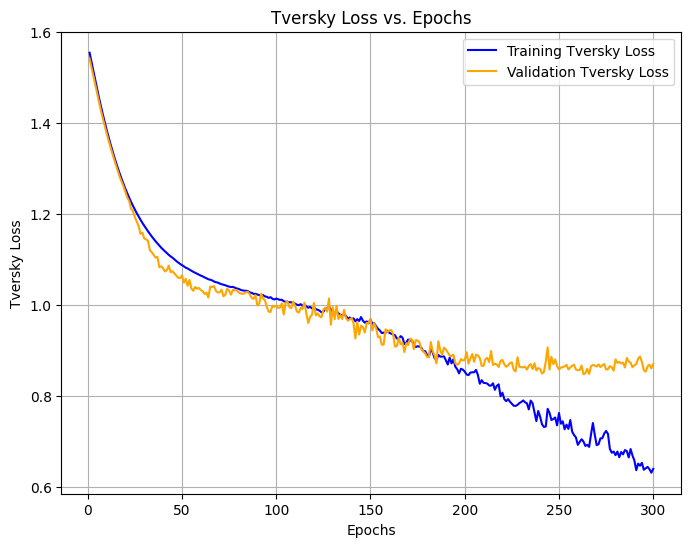

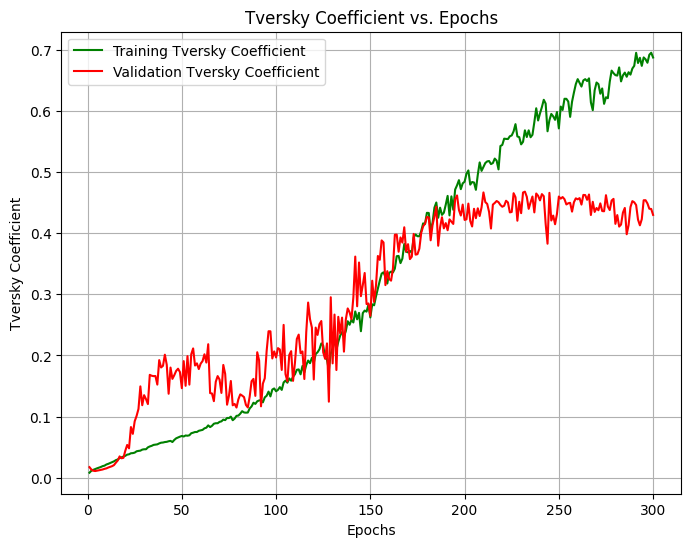

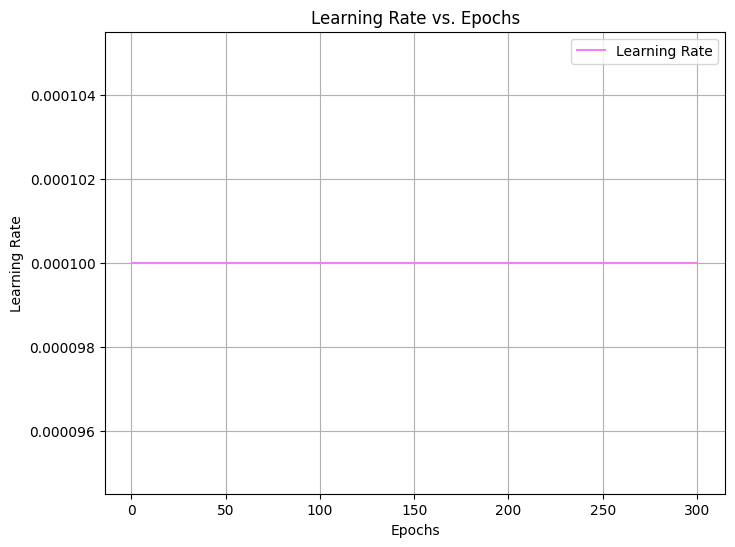


Plots saved to analysis


In [161]:
import seaborn as sns
import matplotlib.pyplot as plt


with open(f"{ANALYSIS}/metrics_{training_timestamp}.json", "r") as f:
    metrics = json.load(f)

epochs = range(1, len(metrics["loss"]) + 1)

plt.figure(figsize=(8, 6))
sns.lineplot(x=epochs, y=metrics["loss"], label="Training Tversky Loss", color="blue")
sns.lineplot(x=epochs, y=metrics["val_loss"], label="Validation Tversky Loss", color="orange")
plt.title("Tversky Loss vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Tversky Loss")
plt.legend()
plt.grid(True)
plt.savefig(f"{ANALYSIS}/tversky_loss_plot_{training_timestamp}.png")
plt.show()

plt.figure(figsize=(8, 6))
sns.lineplot(x=epochs, y=metrics["tversky_coefficient"], label="Training Tversky Coefficient", color="green")
sns.lineplot(x=epochs, y=metrics["val_tversky_coefficient"], label="Validation Tversky Coefficient", color="red")
plt.title("Tversky Coefficient vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Tversky Coefficient")
plt.legend()
plt.grid(True)
plt.savefig(f"{ANALYSIS}/tversky_coefficient_plot_{training_timestamp}.png")
plt.show()

plt.figure(figsize=(8, 6))
sns.lineplot(x=epochs, y=metrics["learning_rate"], label="Learning Rate", color="violet")
plt.title("Learning Rate vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Learning Rate")
plt.legend()
plt.grid(True)
plt.savefig(f"{ANALYSIS}/learning_rate_{training_timestamp}.png")
plt.show()

print(f"\nPlots saved to {ANALYSIS}")

## Step 10: Test the Model

In [92]:
start_time = time.time()
results = model.predict(features_test, verbose=1)
prediction_duration = time.time() - start_time
image_prediction_time = prediction_duration / len(features_test)

predictions = (results.squeeze(-1) > 0.5).astype("int32")
predictions_flat = predictions.flatten()
labels_test_flat = labels_test.flatten()

print(f"Total prediction time: {prediction_duration:.4f} seconds")
print(f"Time per spatial map: {image_prediction_time:.4f} seconds")

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 618ms/step
Total prediction time: 2.5559 seconds
Time per spatial map: 0.0328 seconds


## Step 11: Display the Results

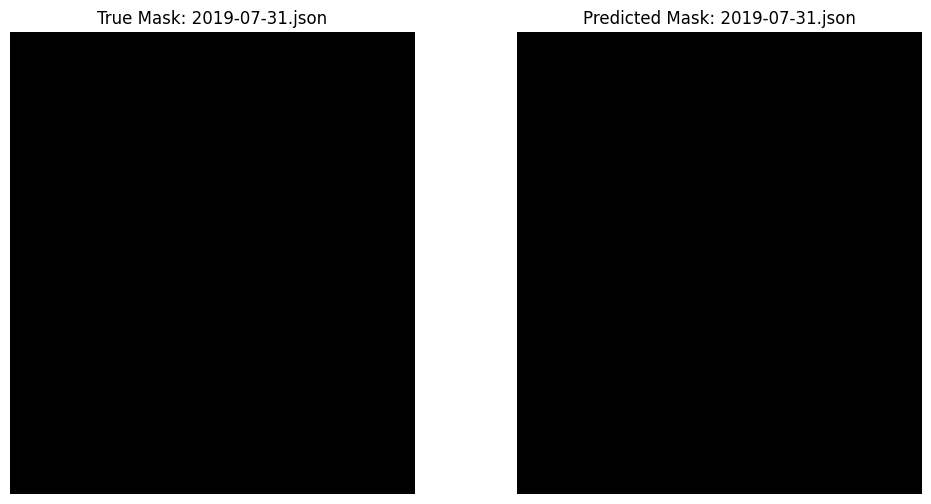

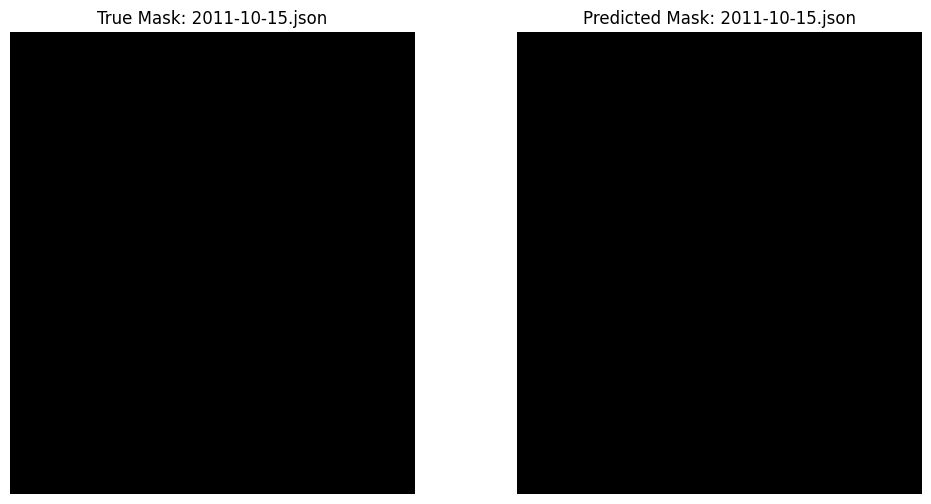

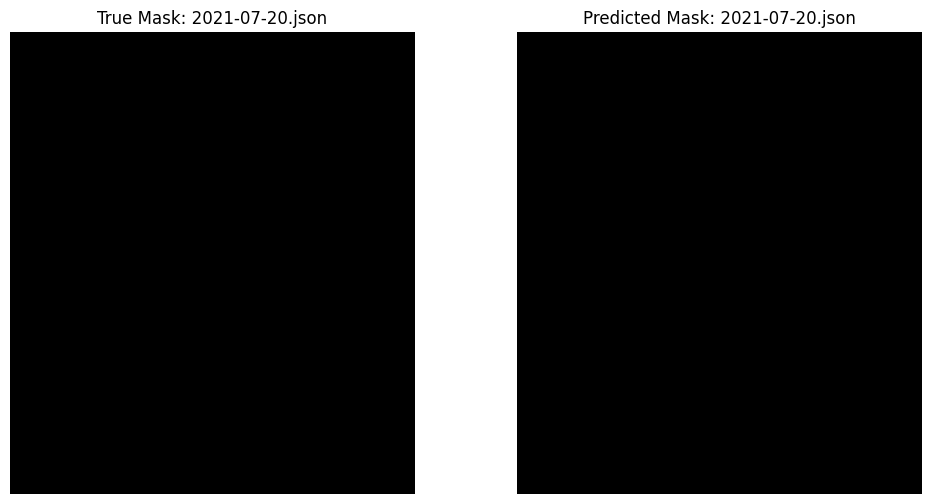

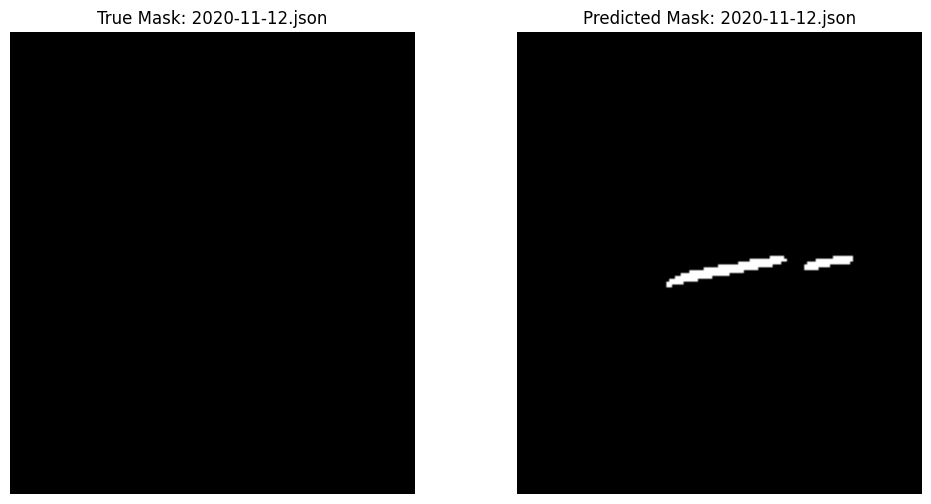

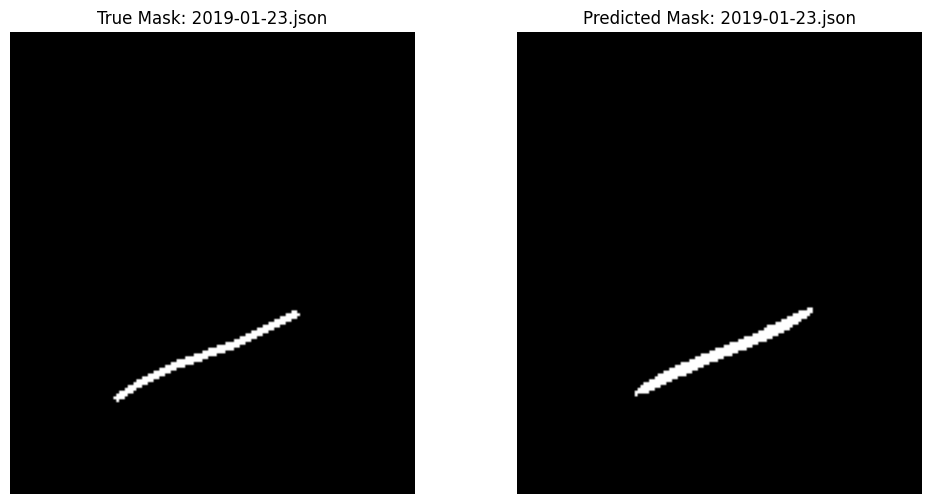

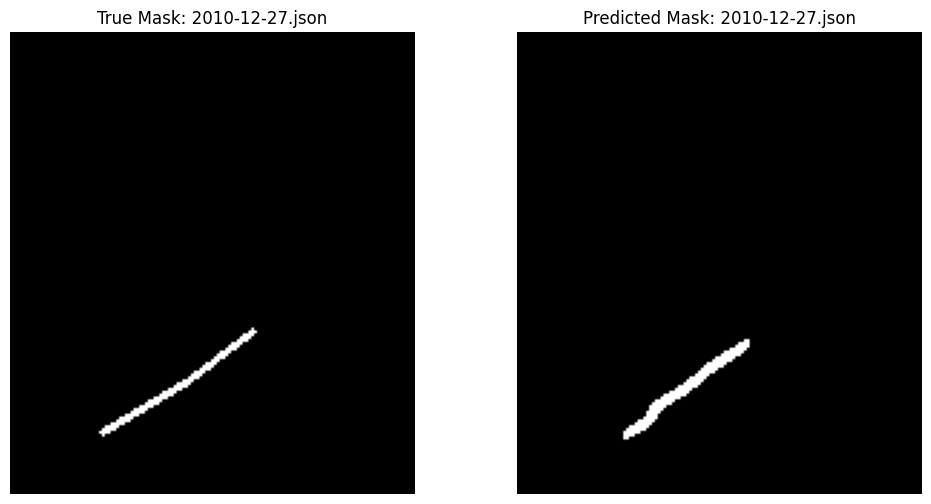

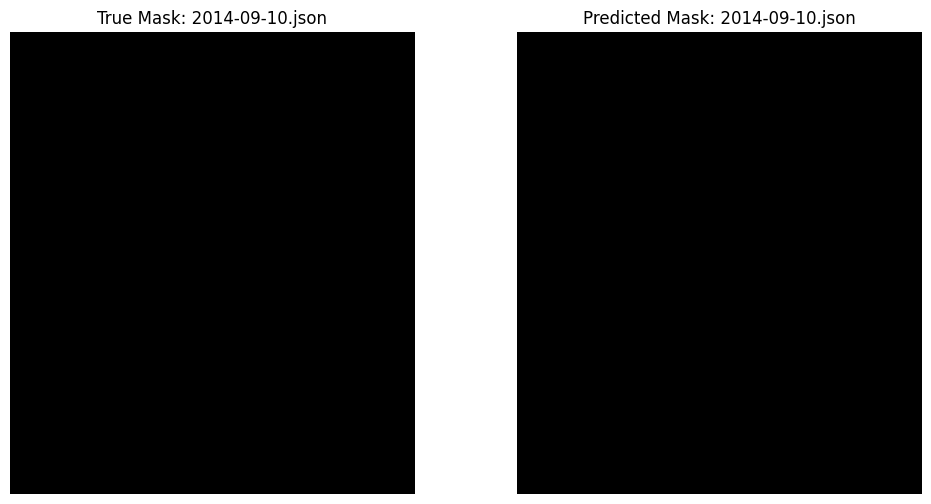

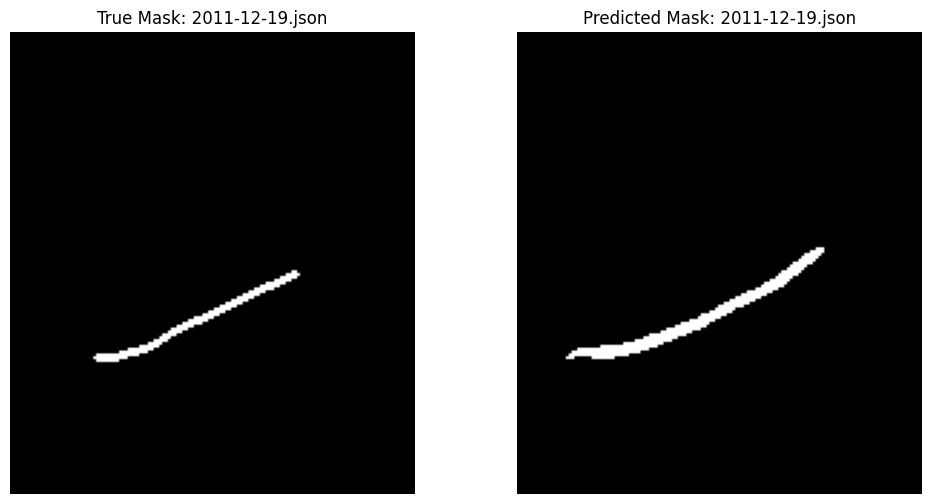

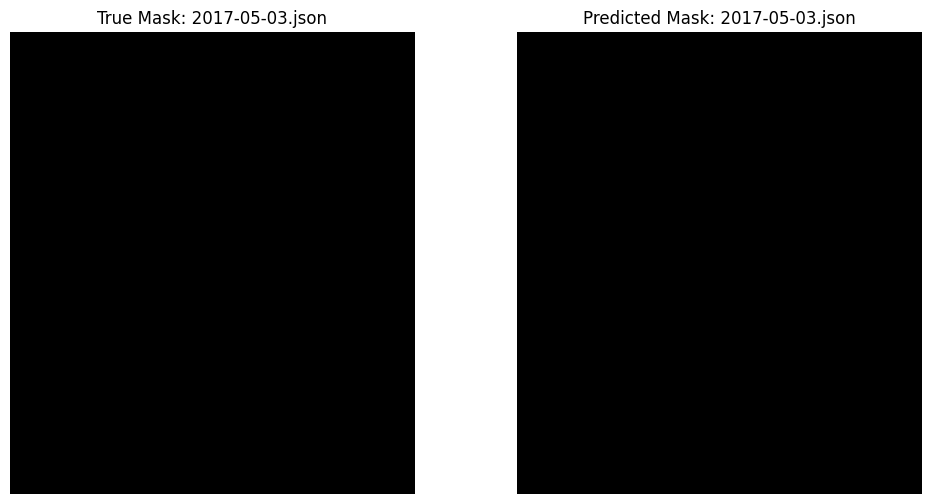

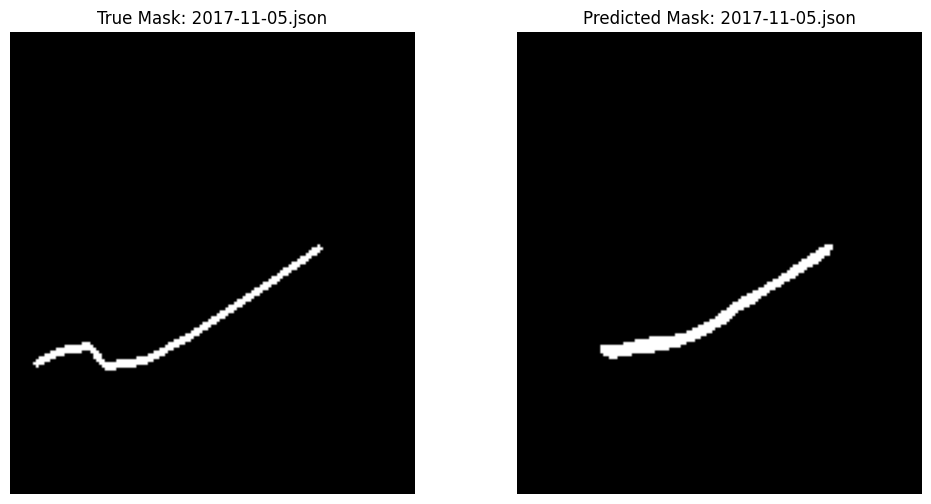

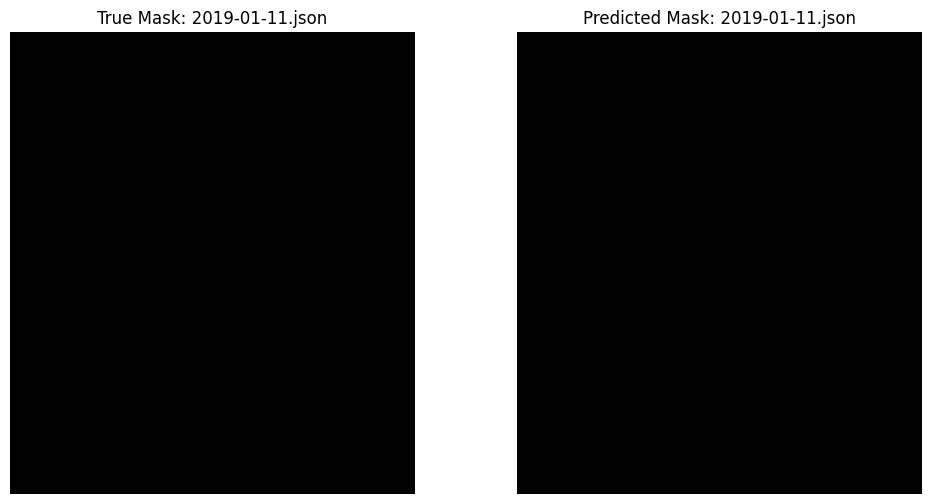

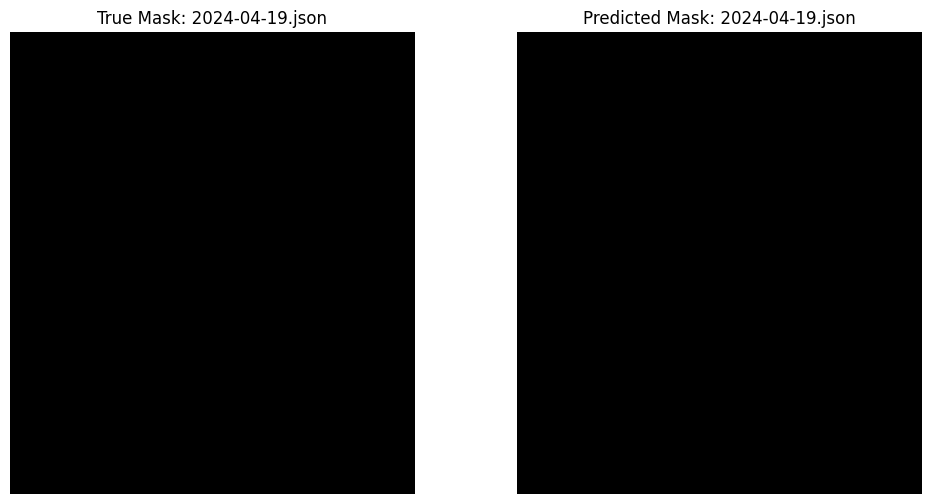

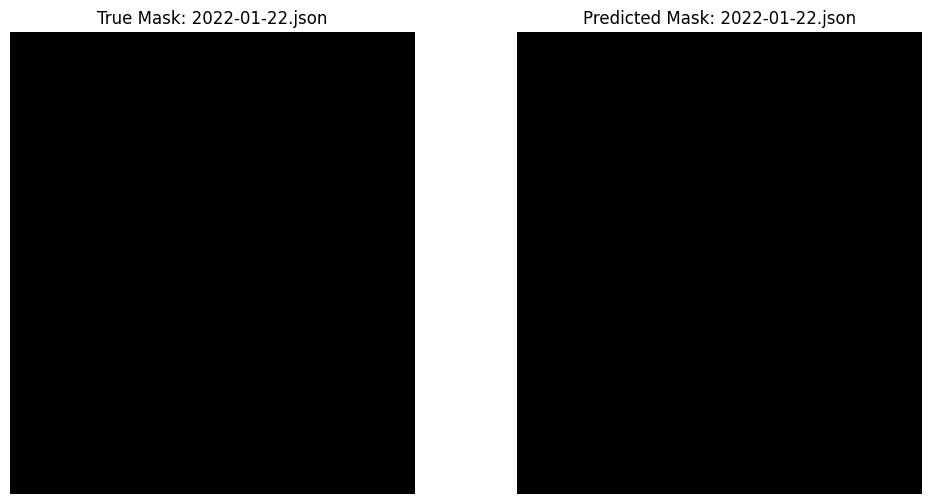

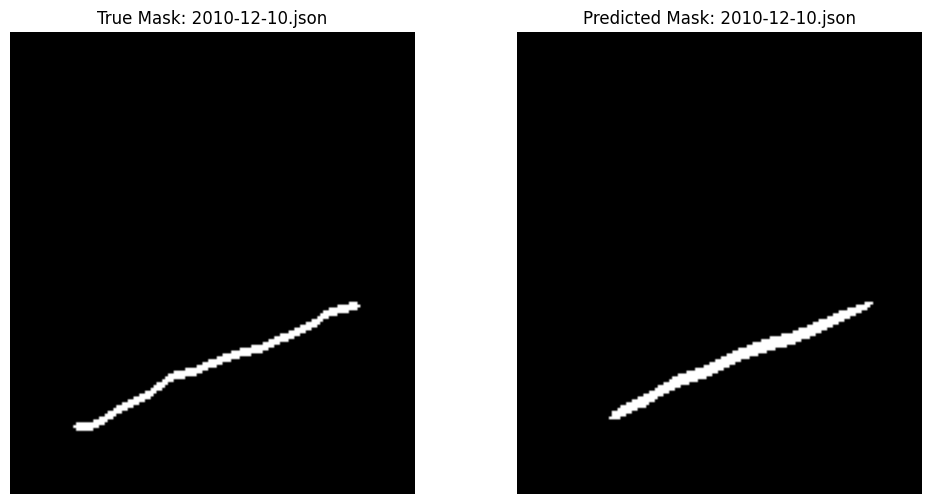

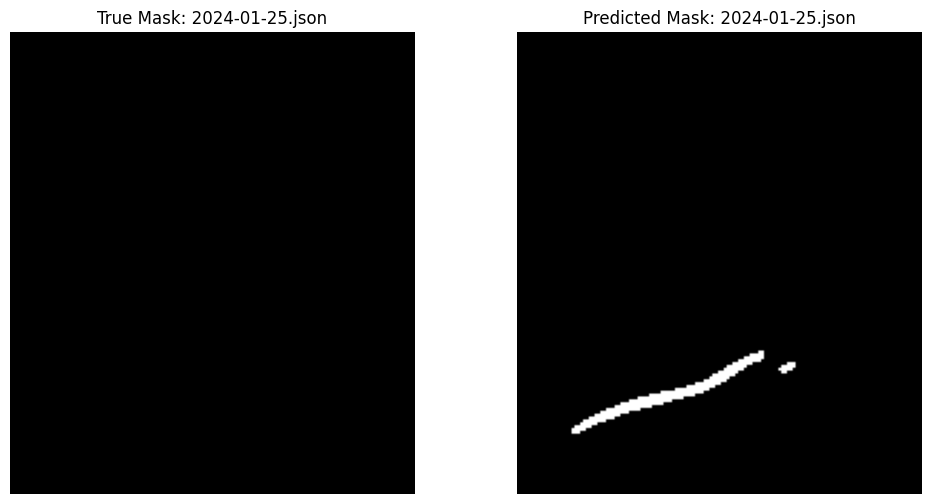

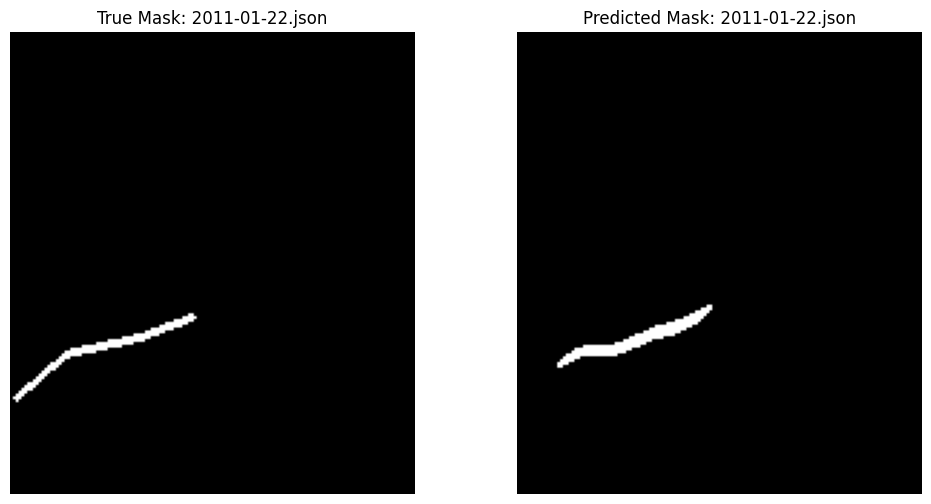

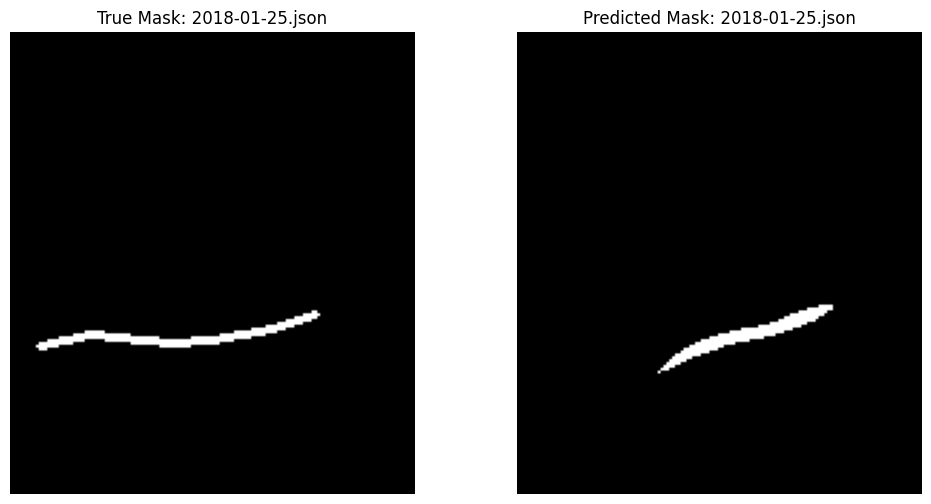

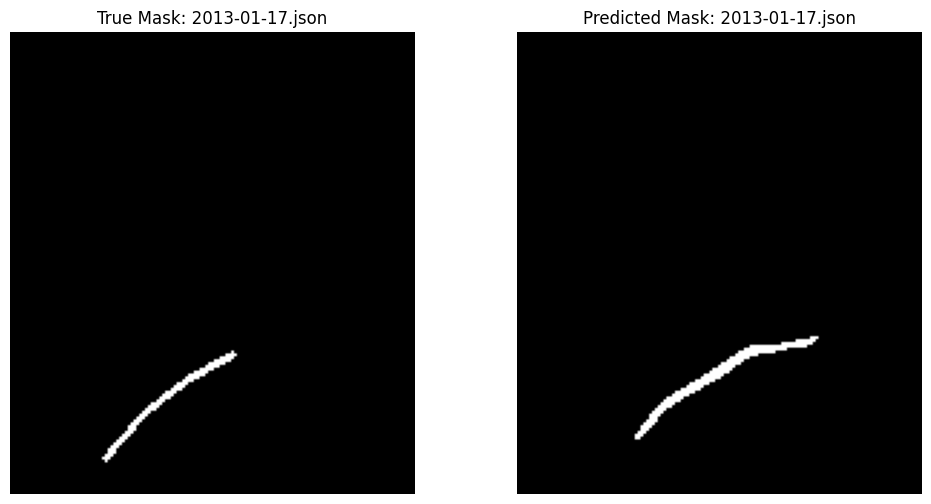

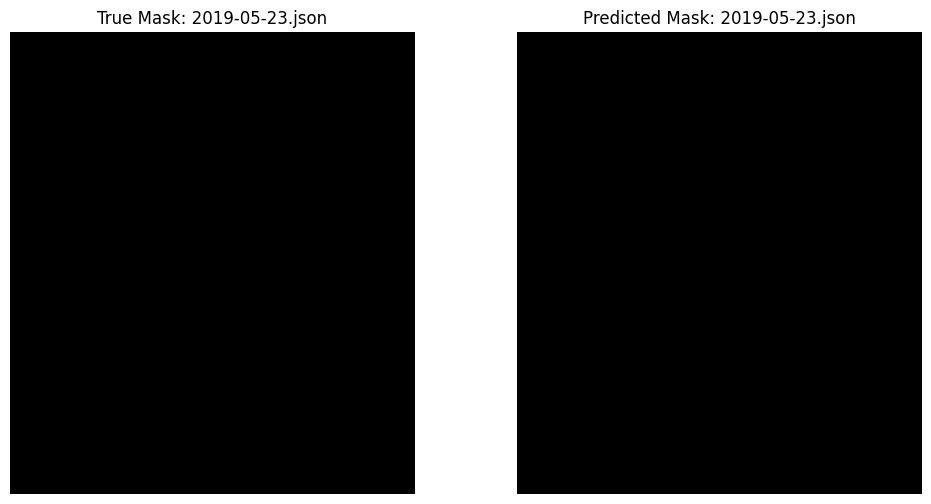

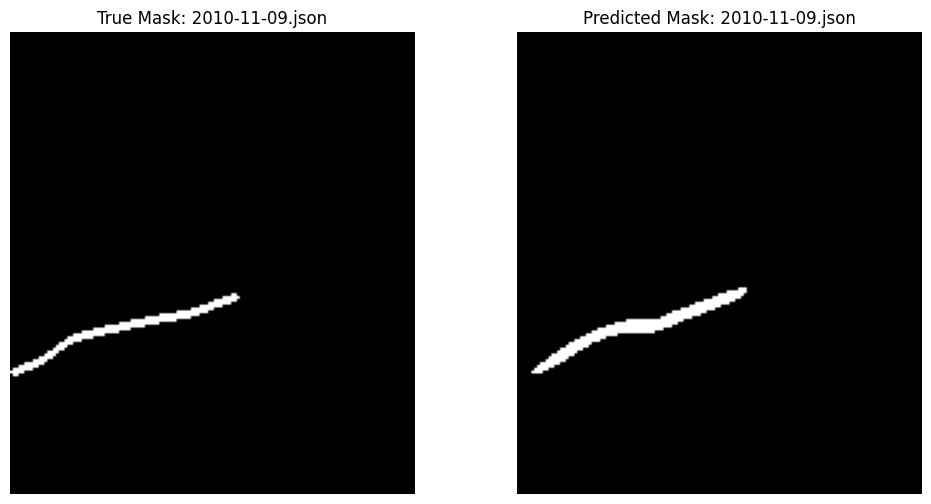

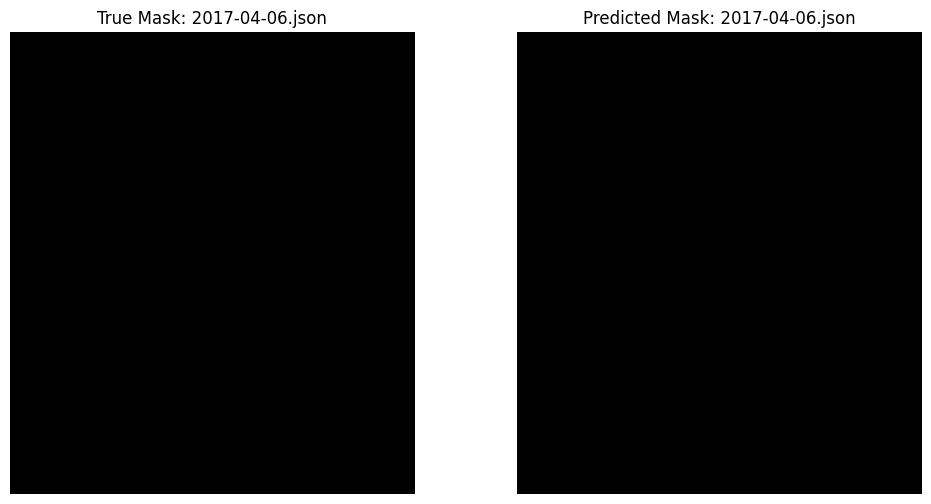

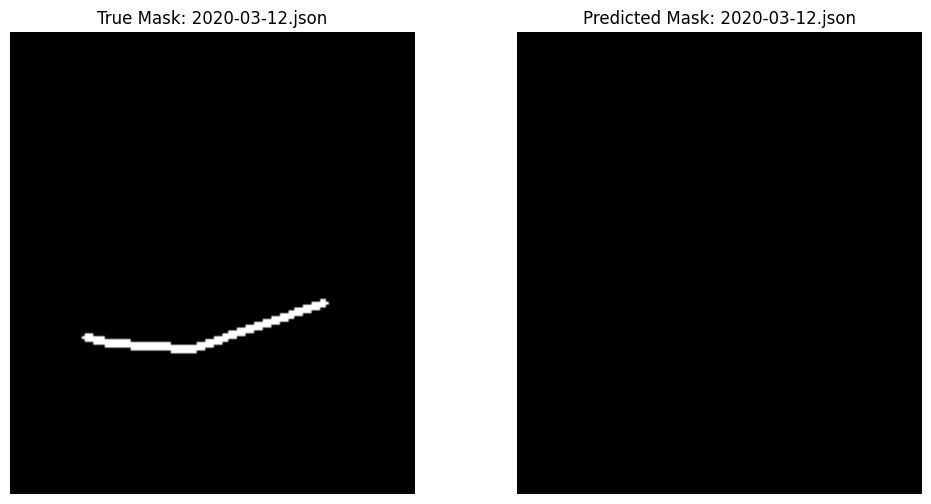

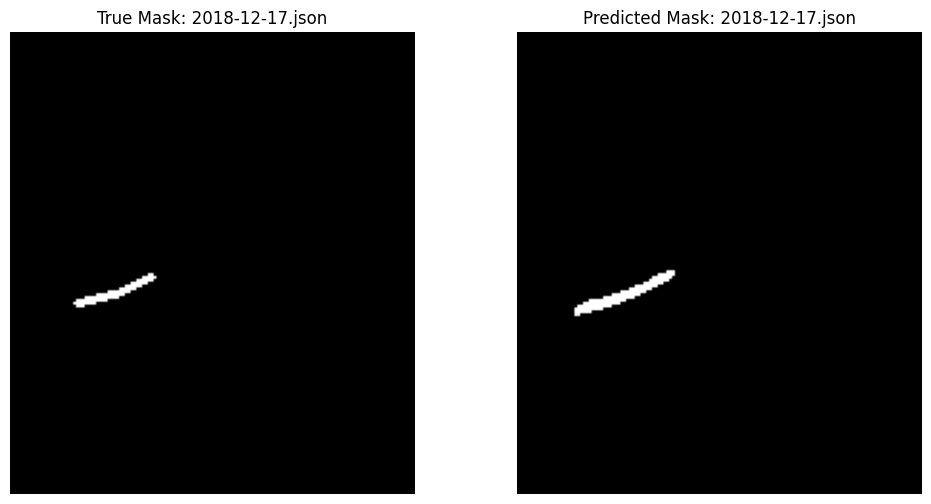

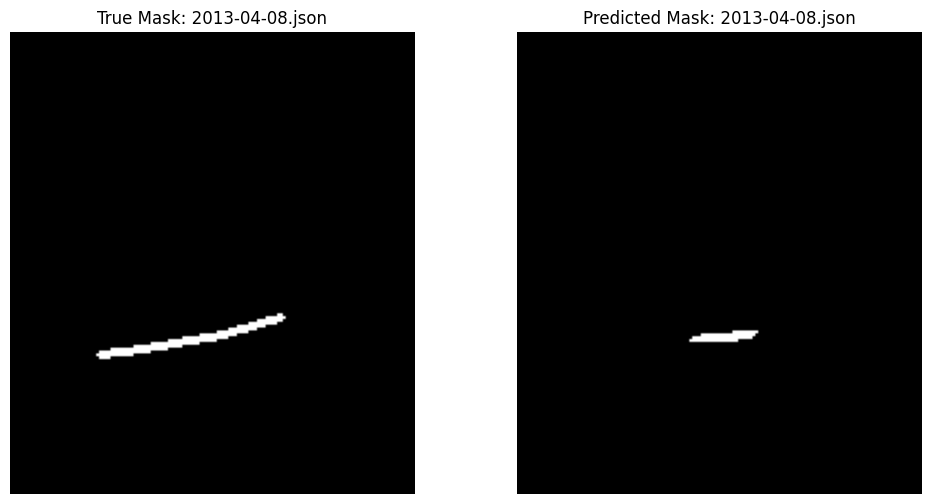

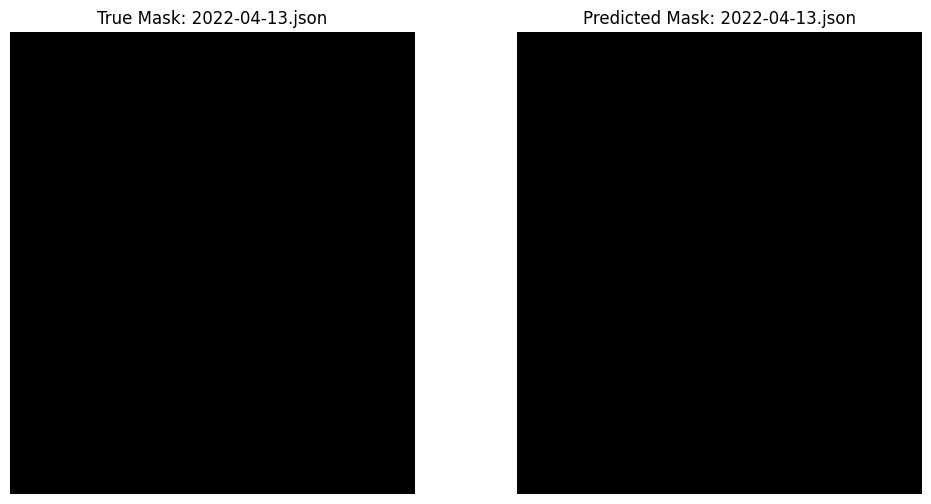

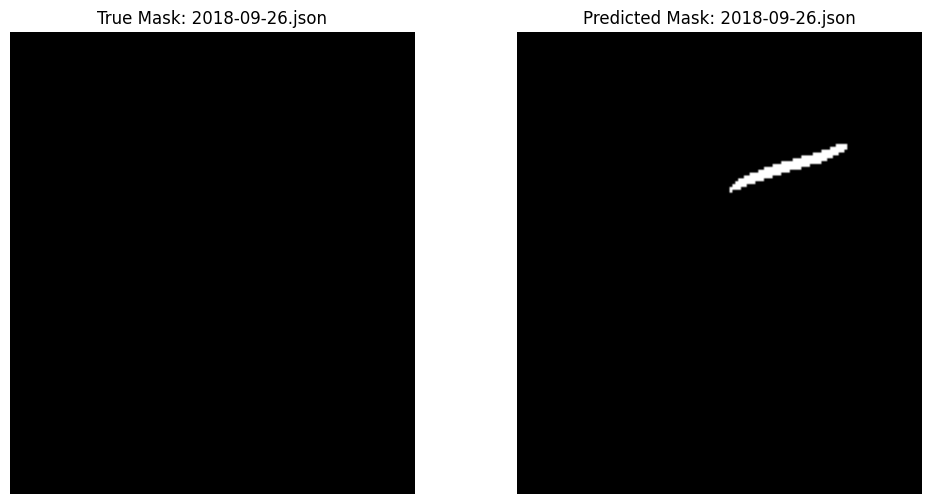

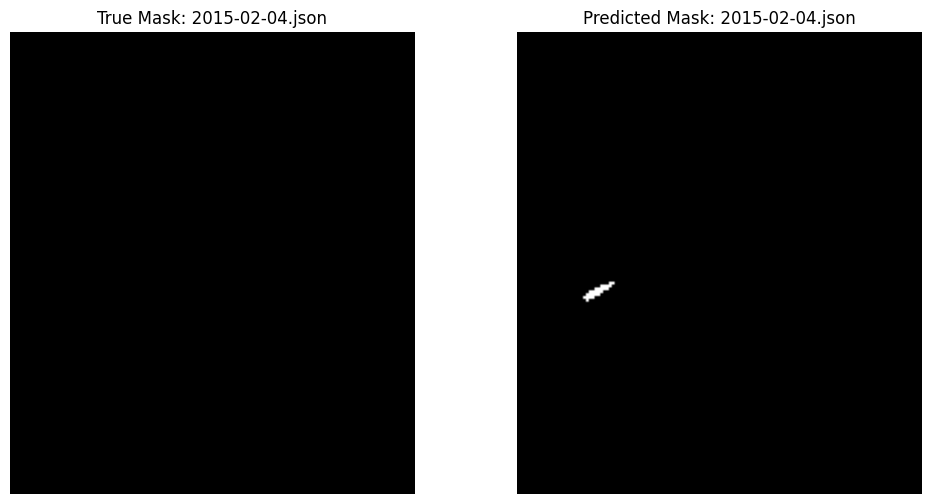

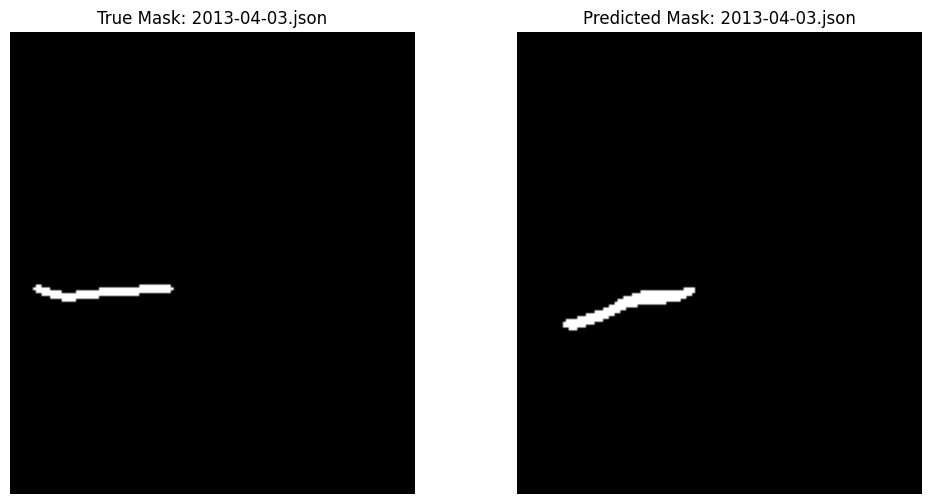

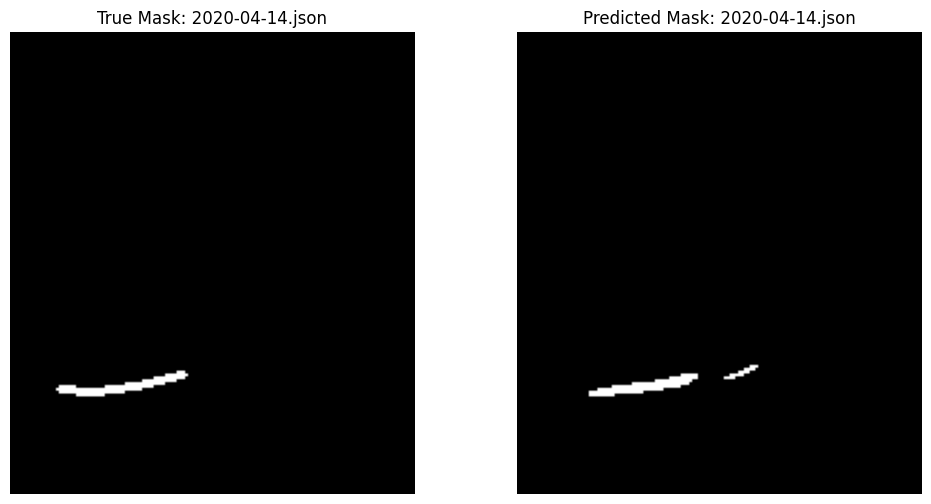

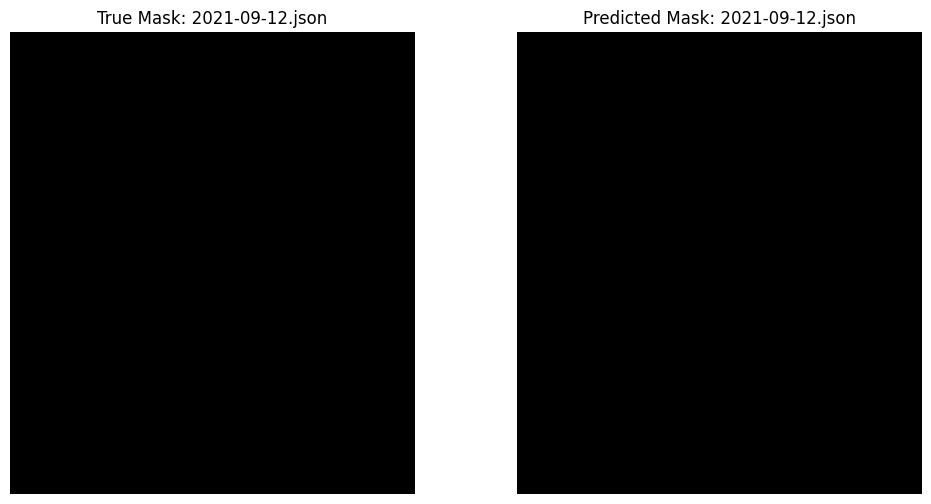

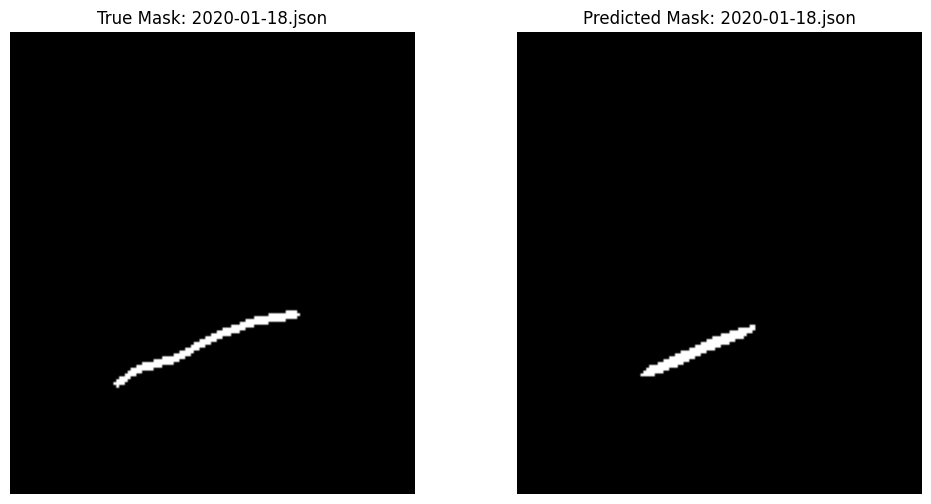

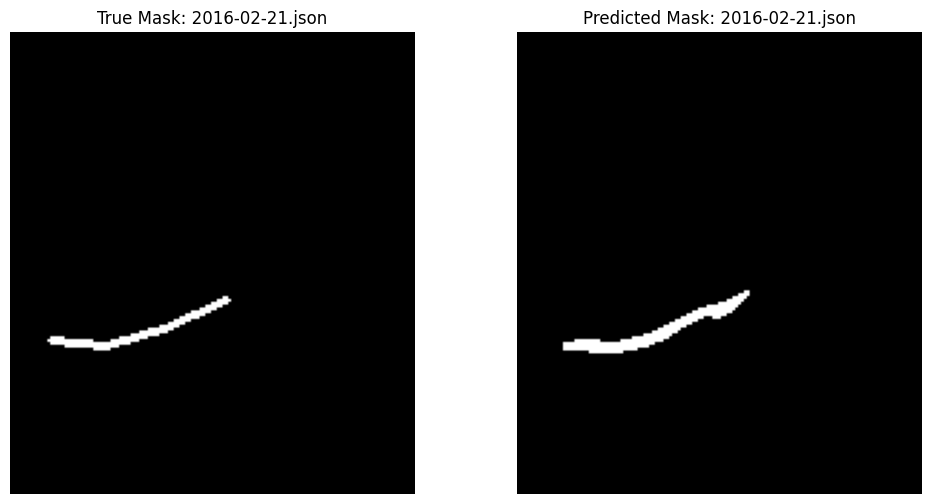

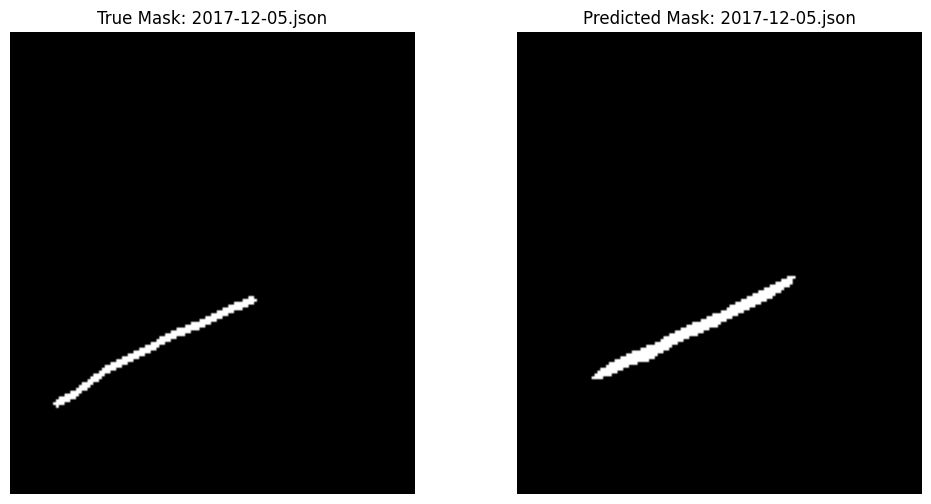

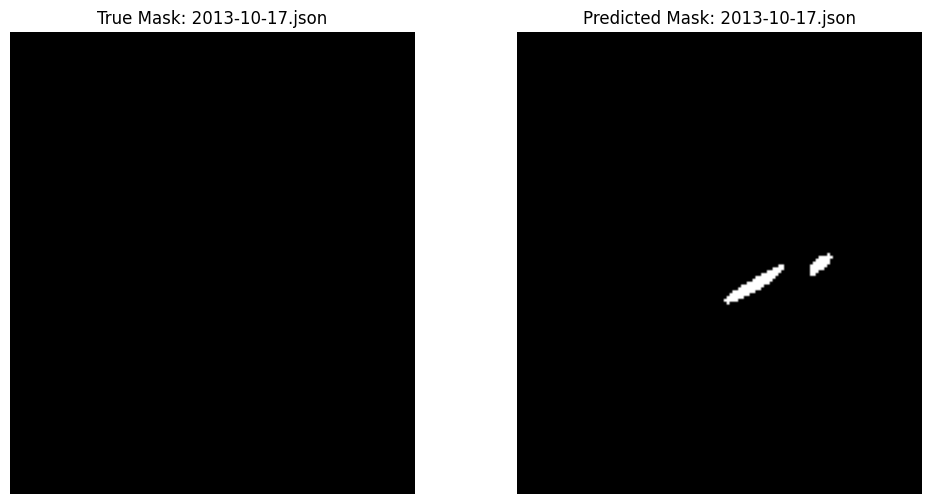

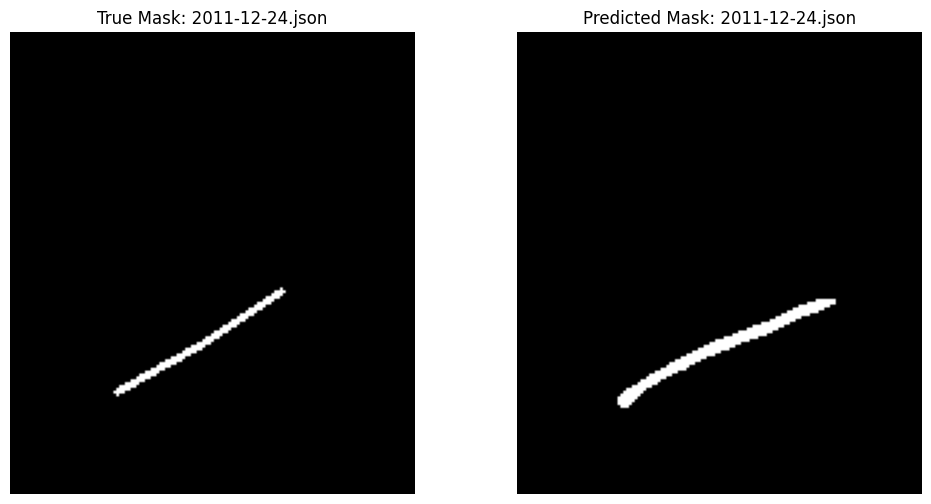

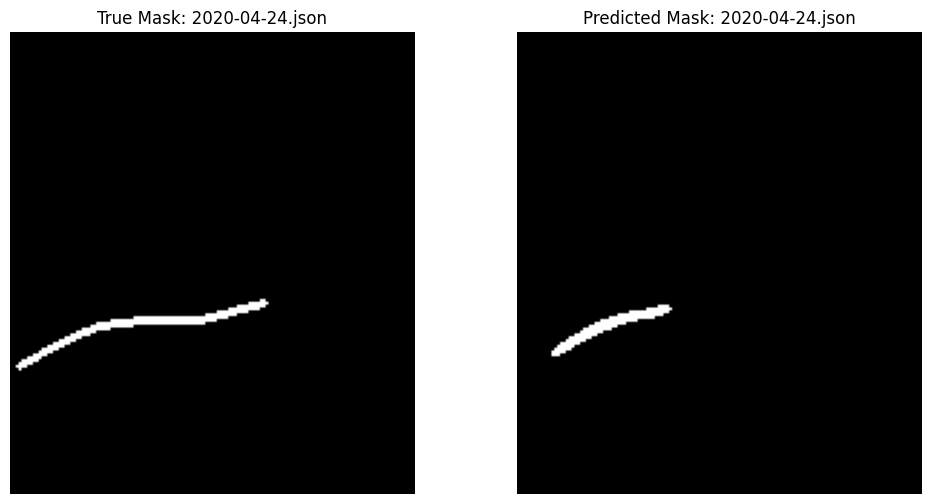

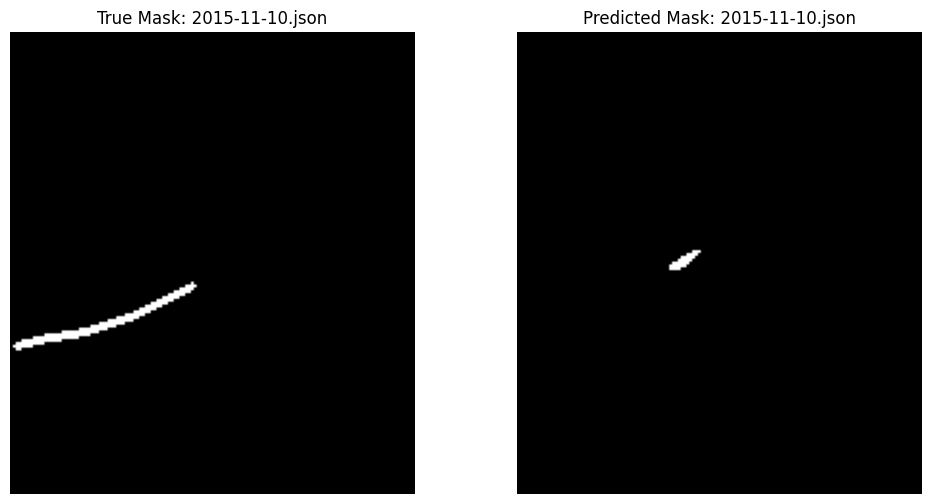

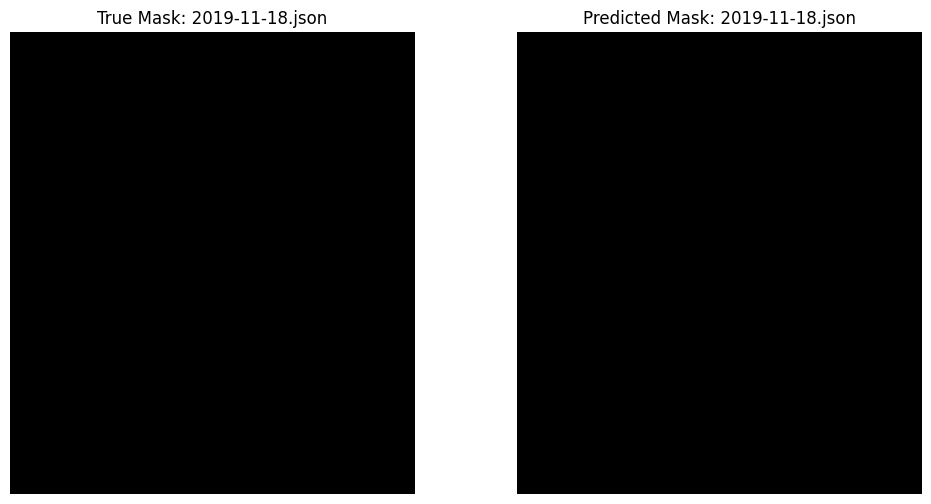

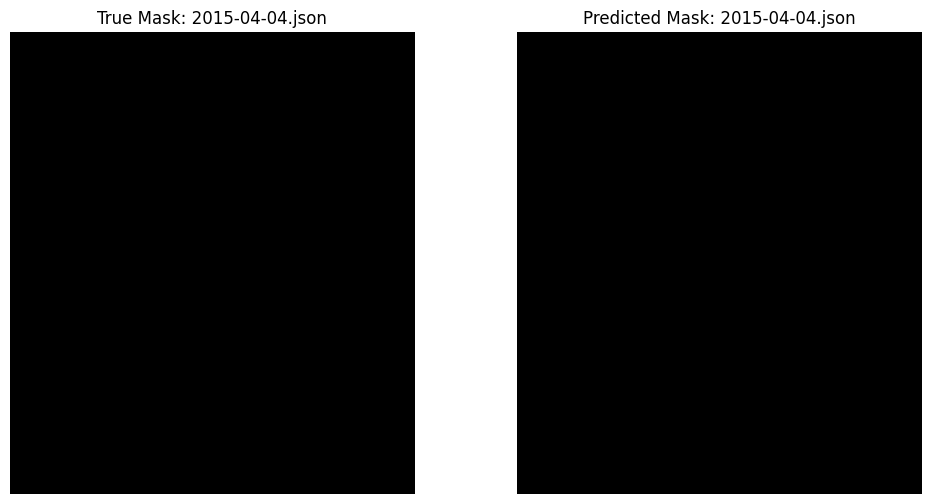

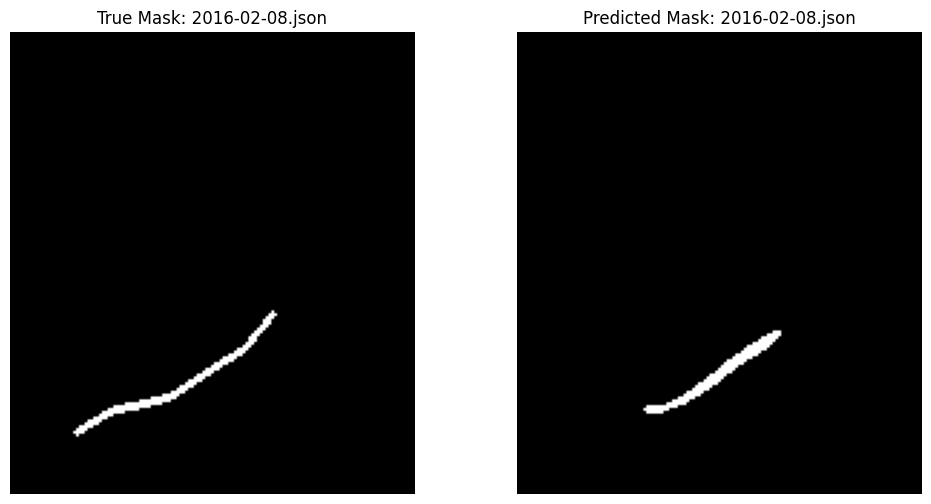

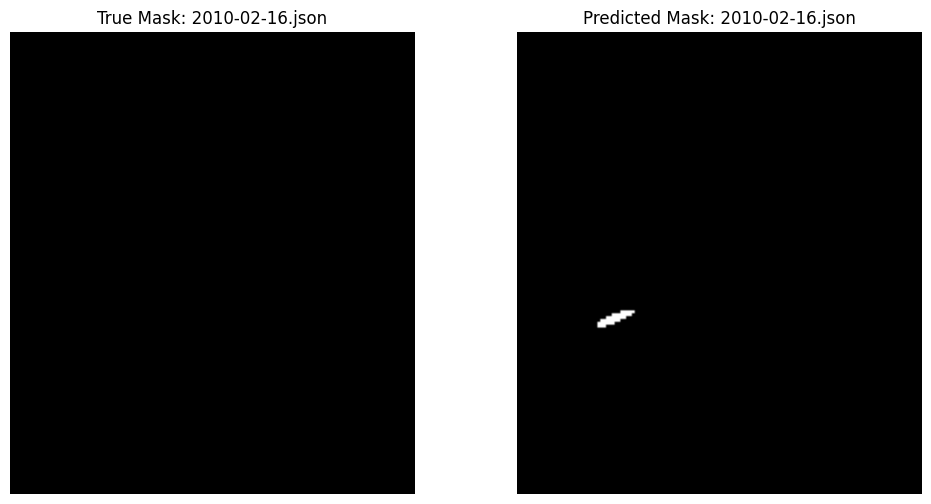

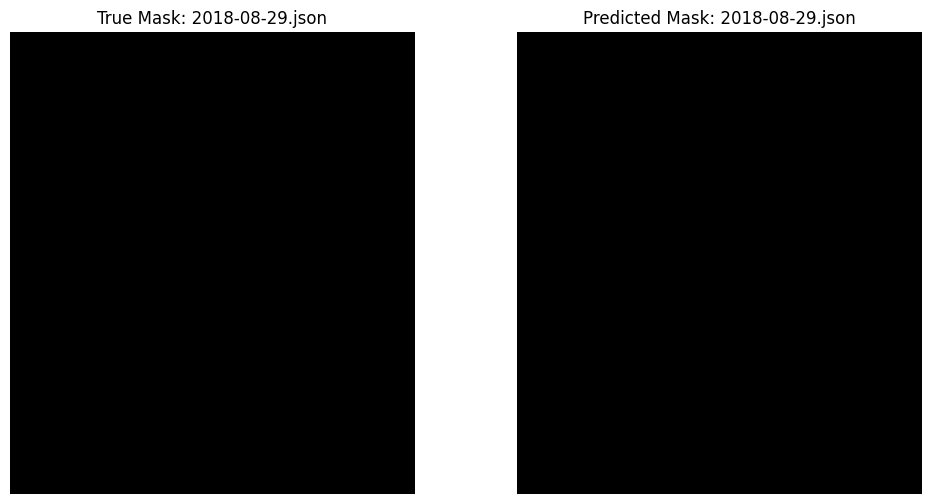

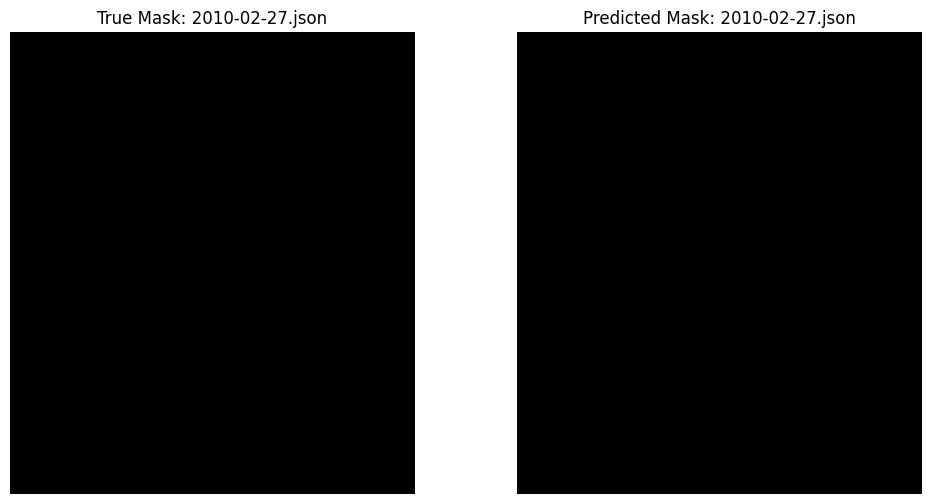

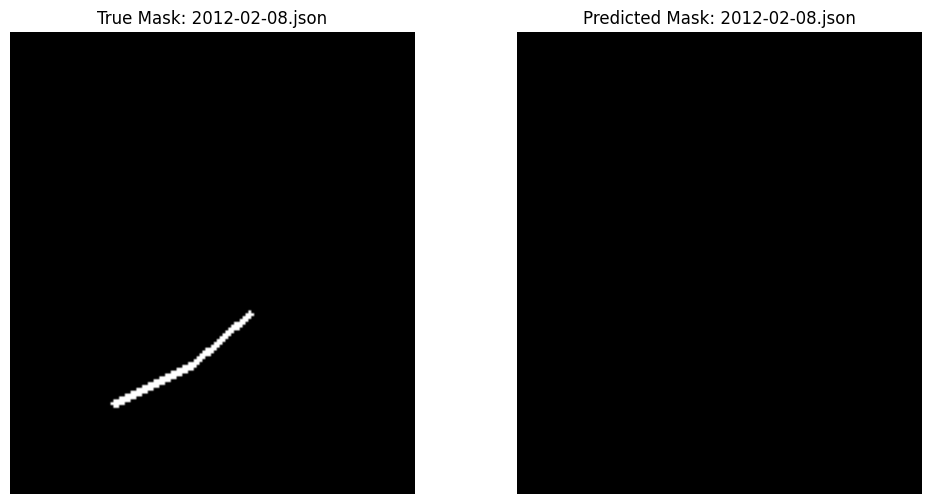

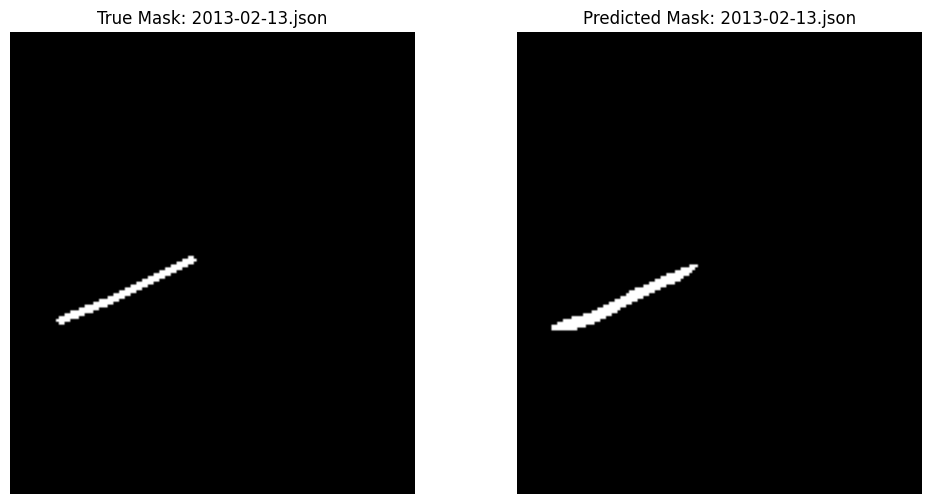

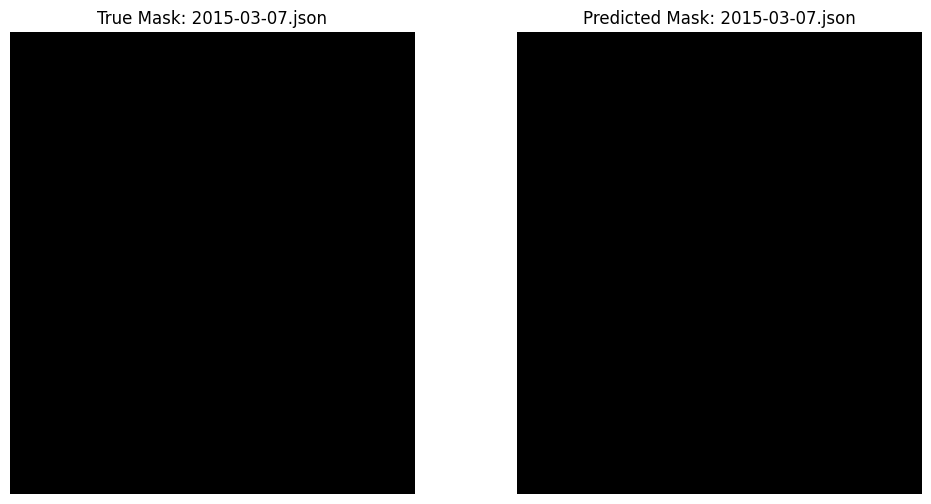

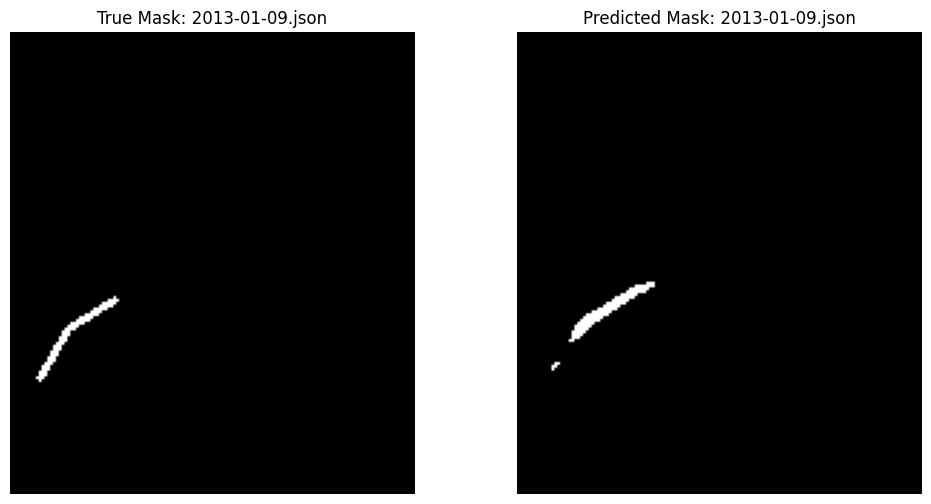

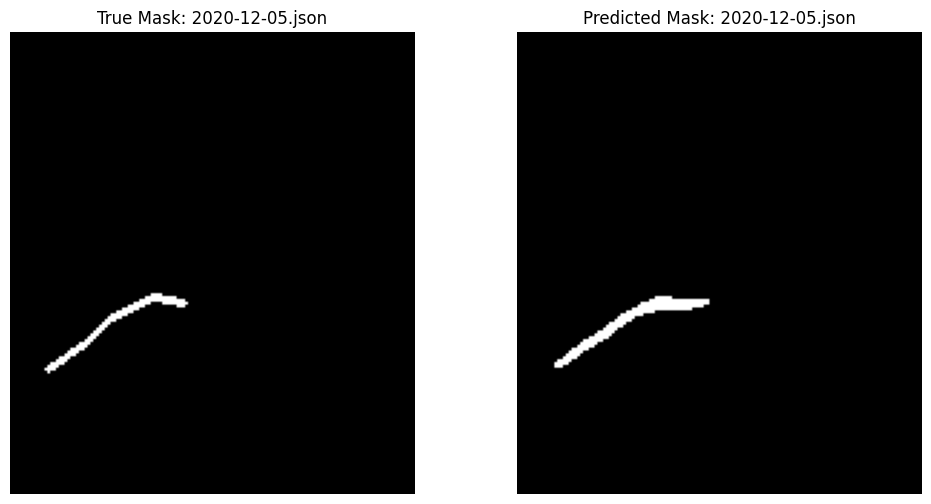

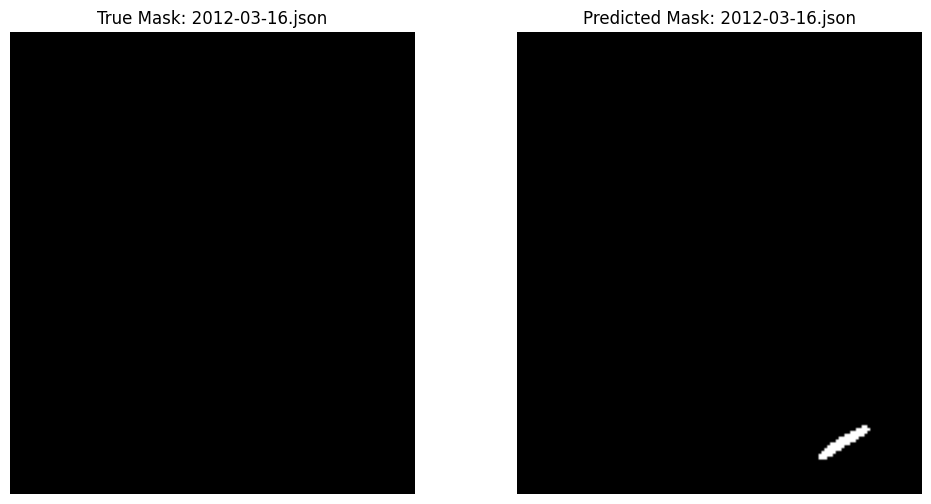

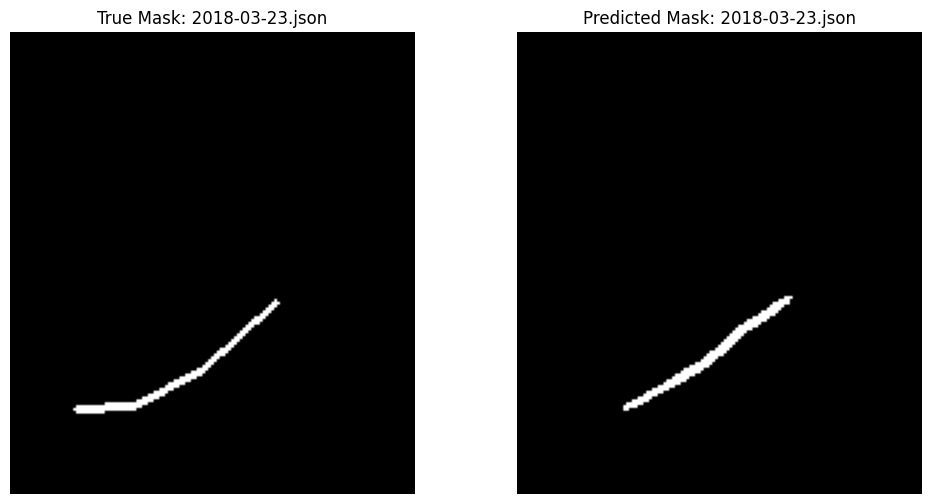

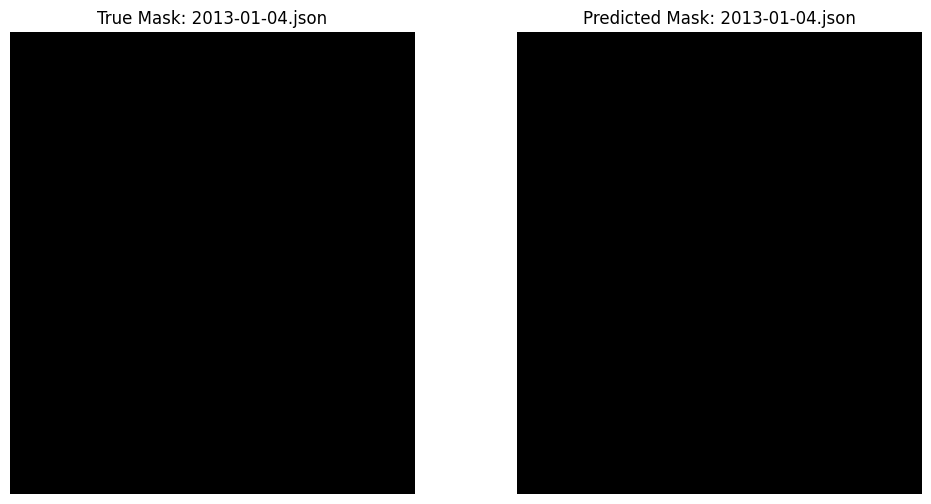

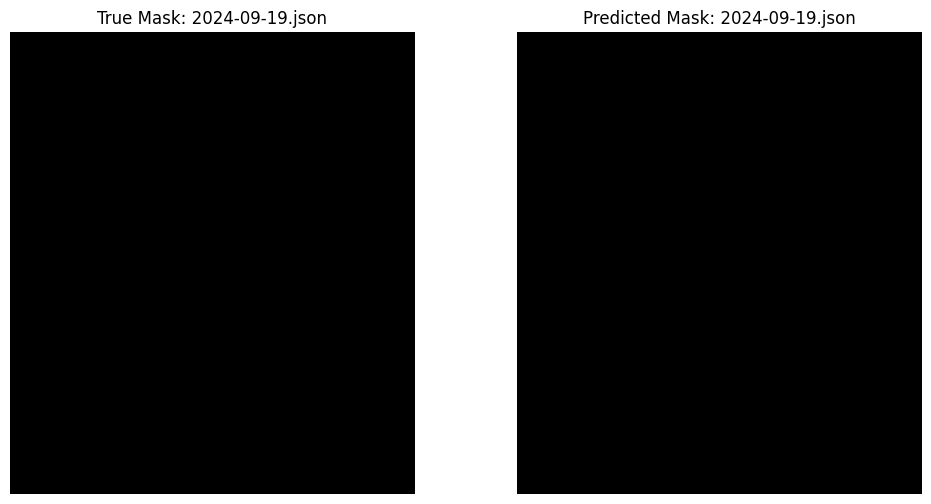

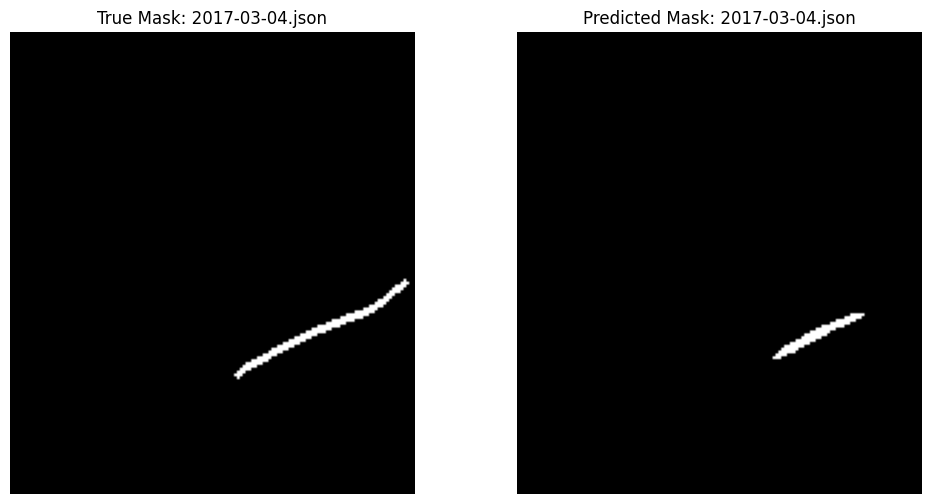

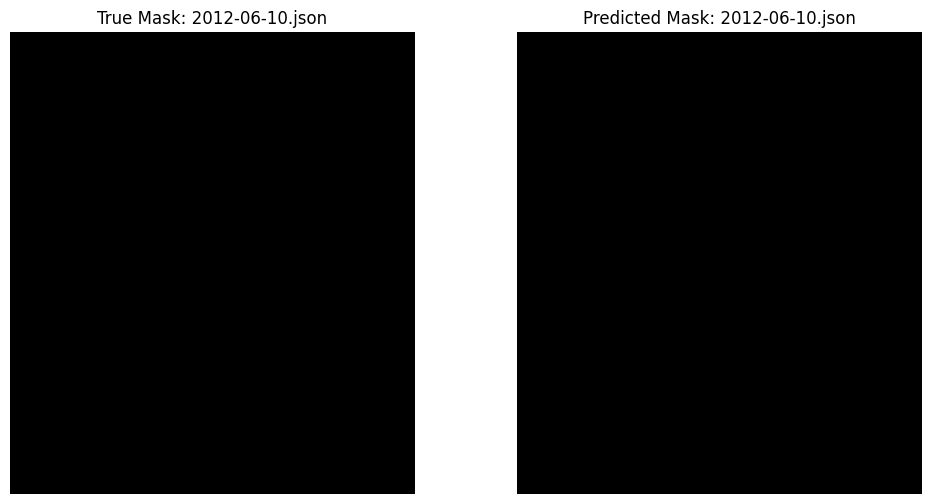

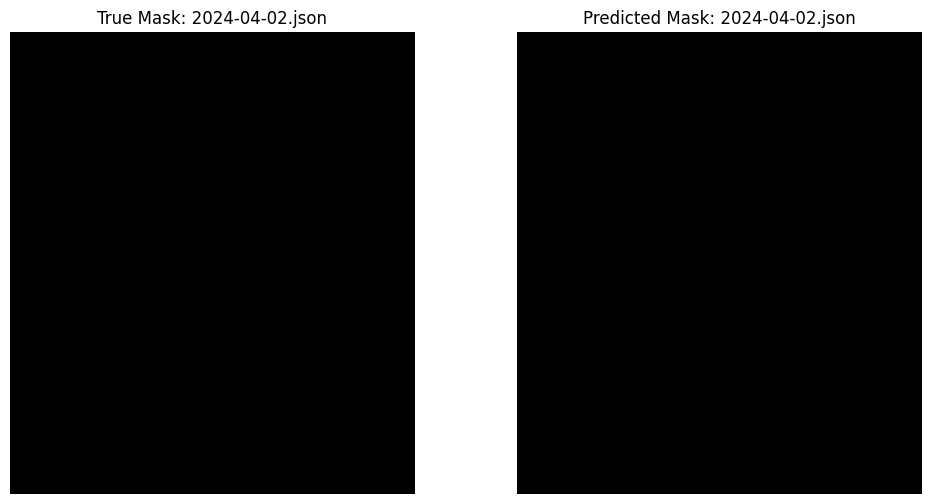

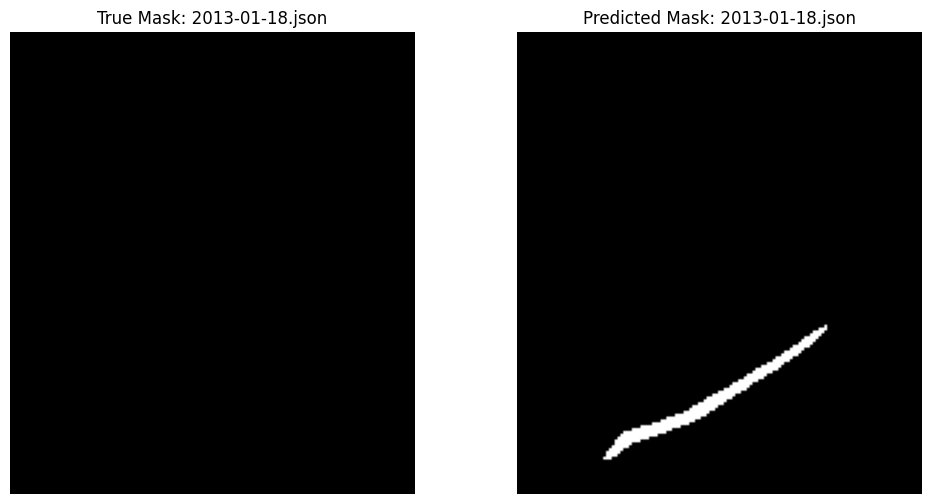

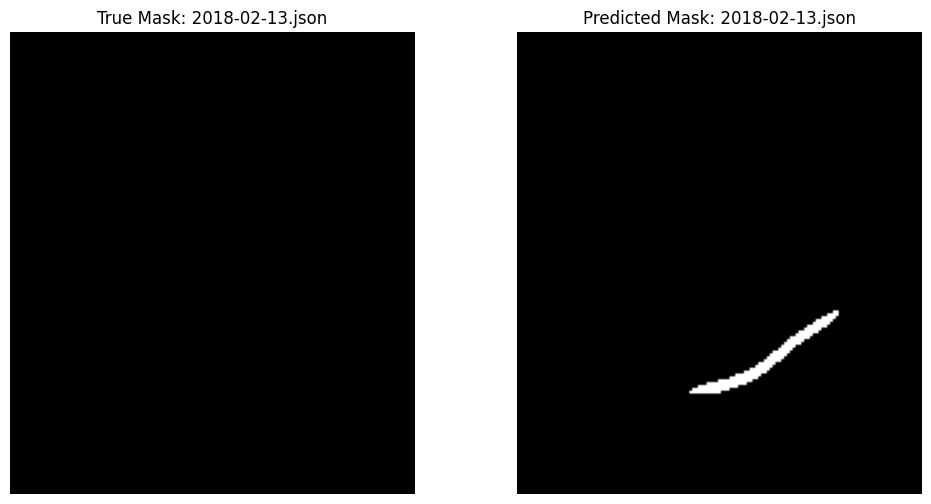

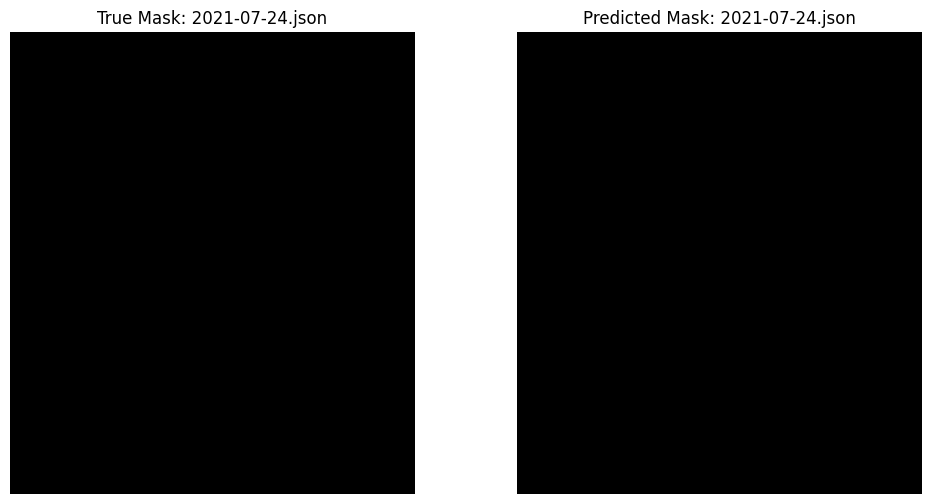

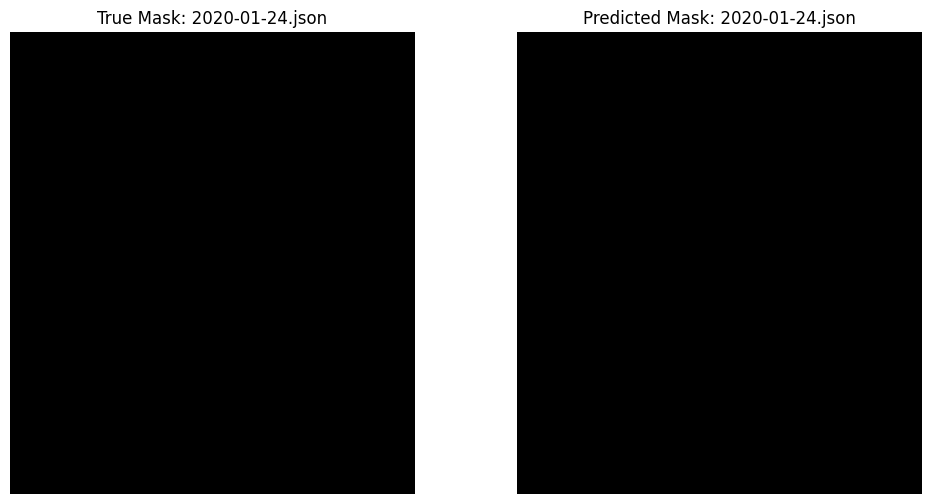

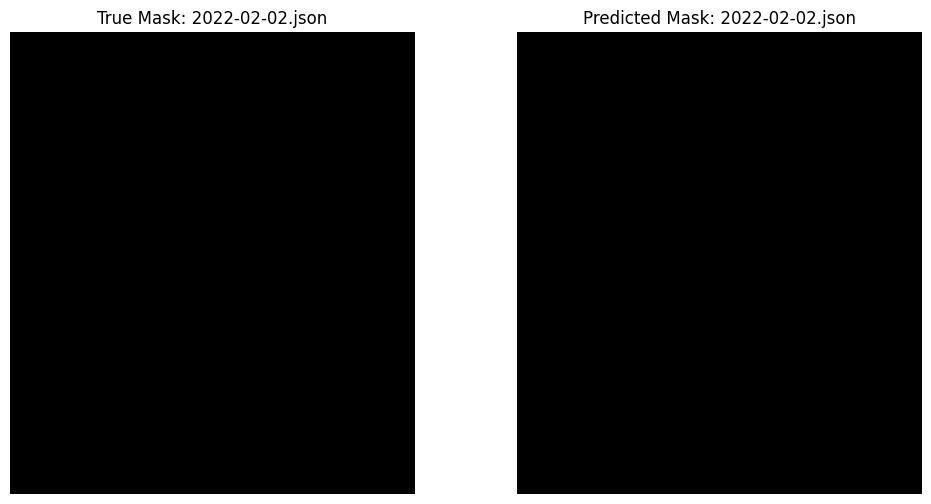

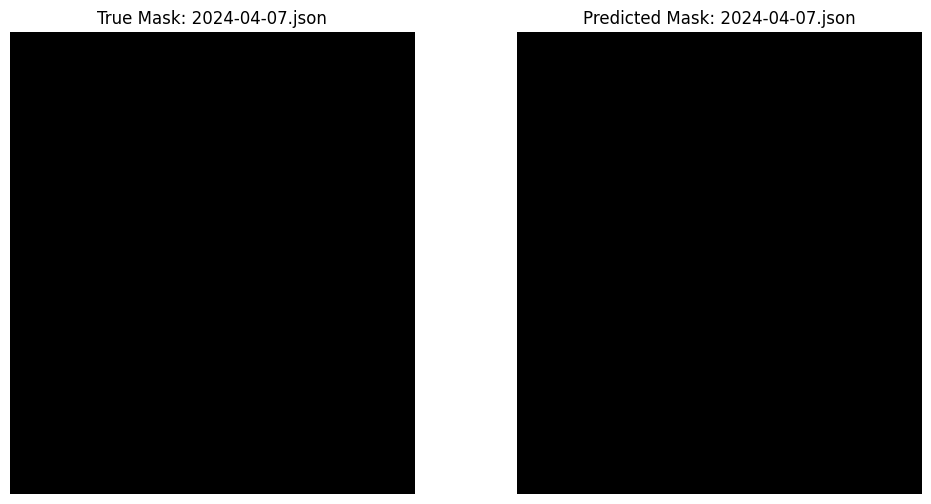

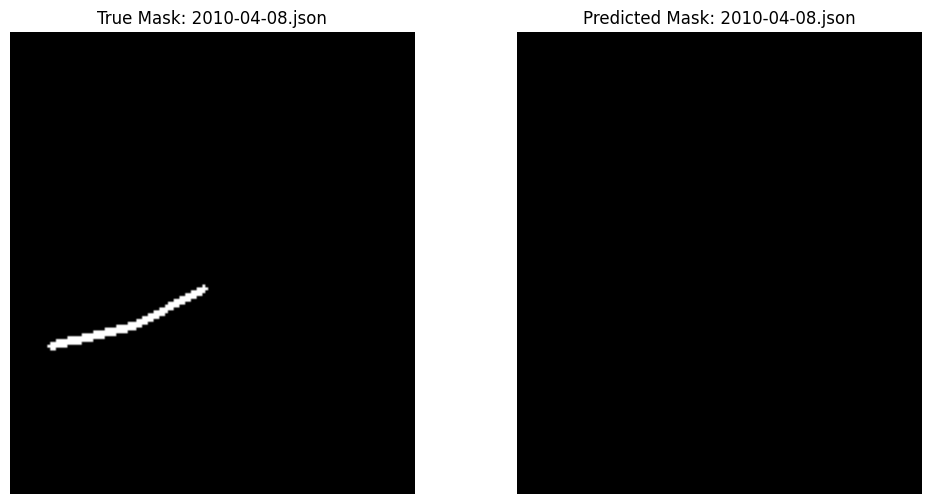

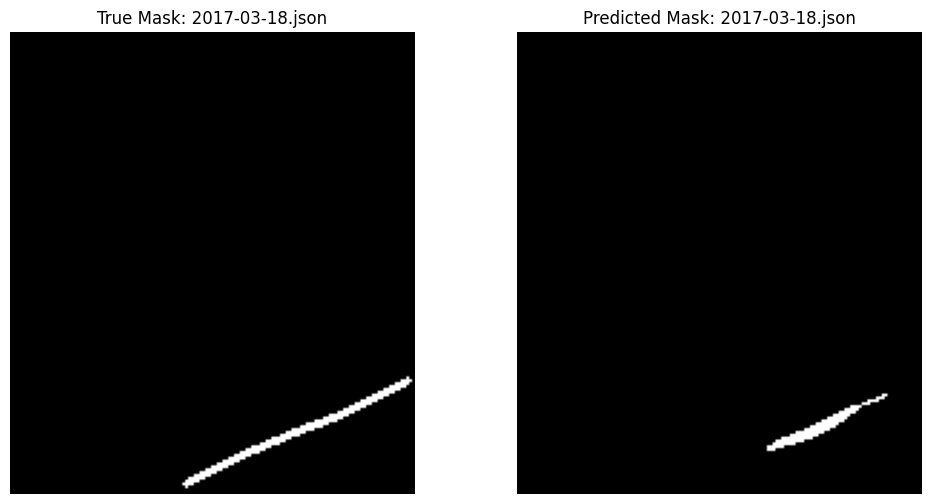

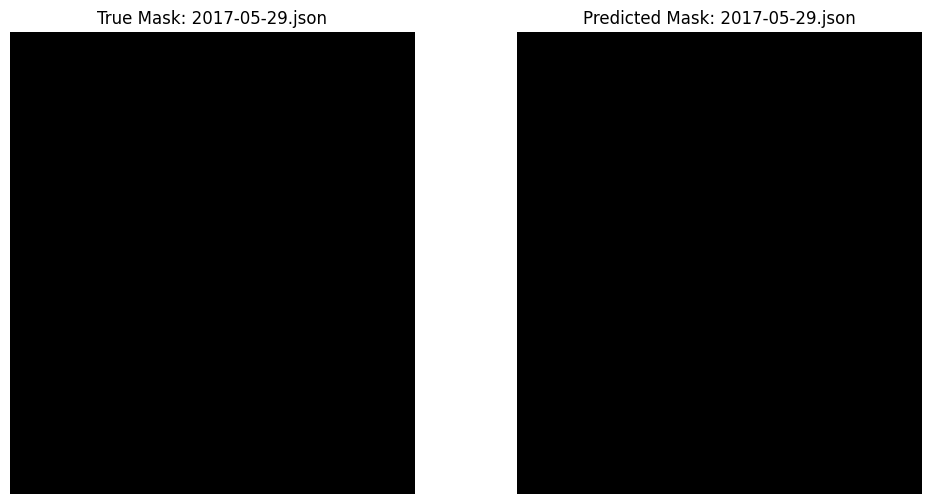

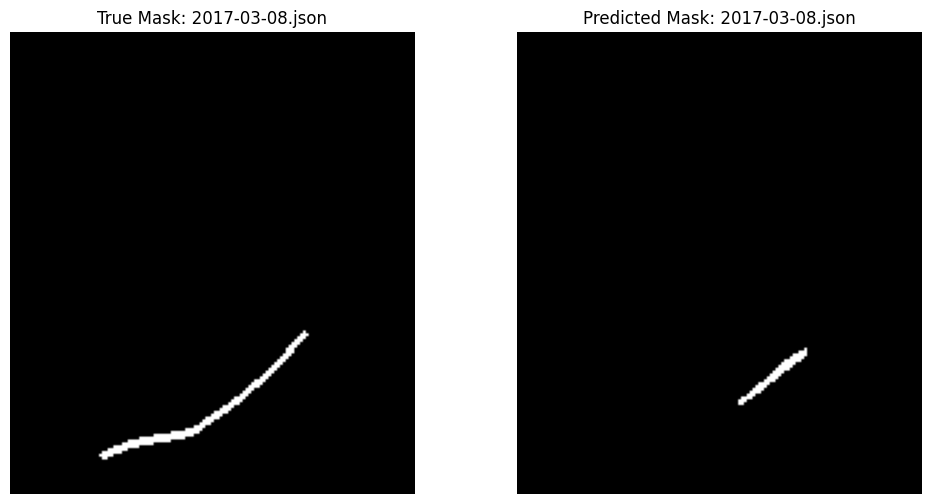

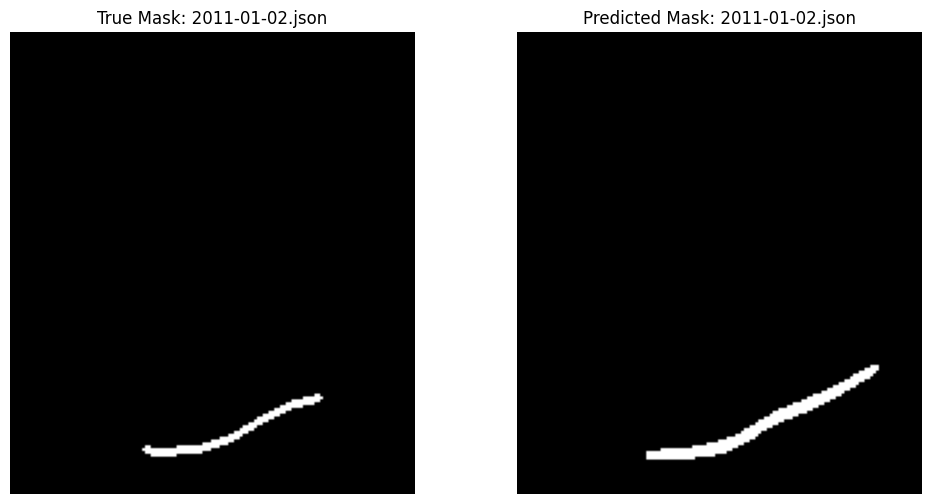

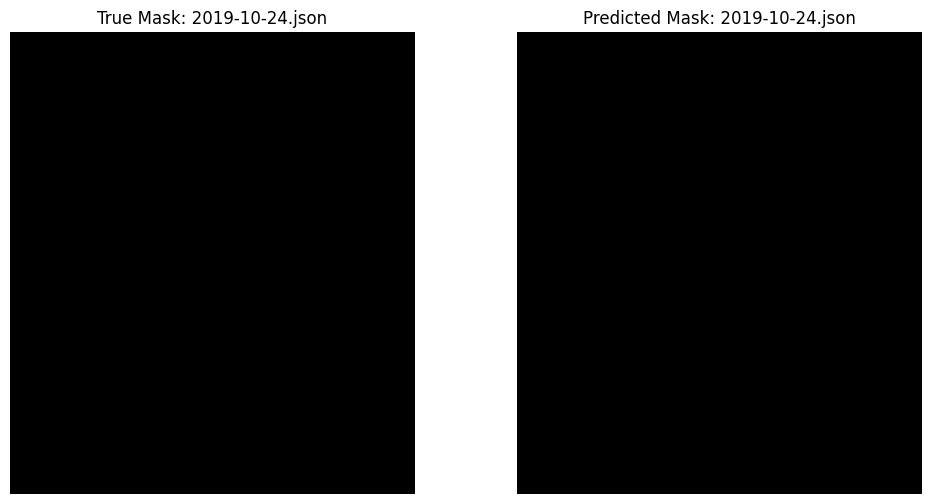

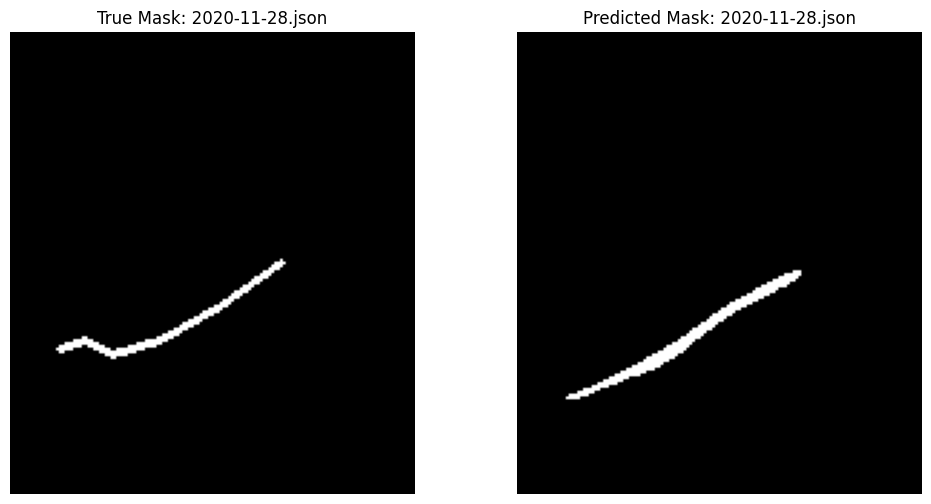

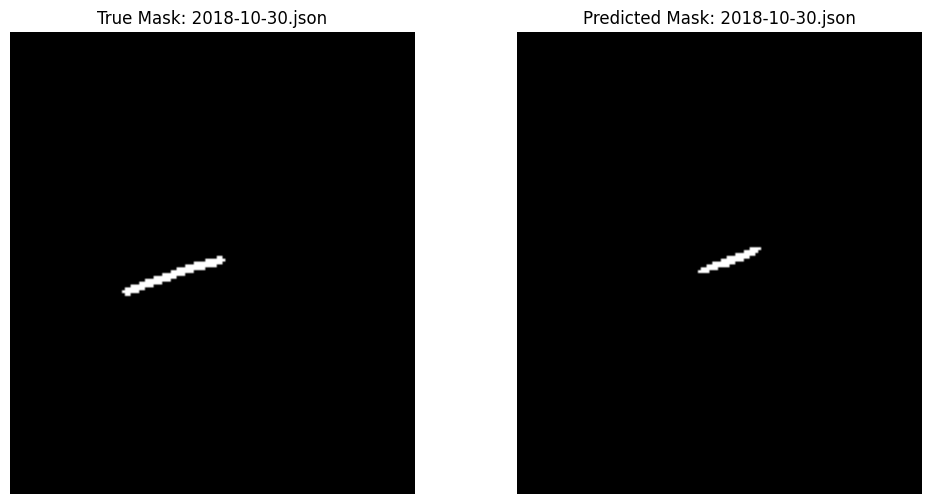

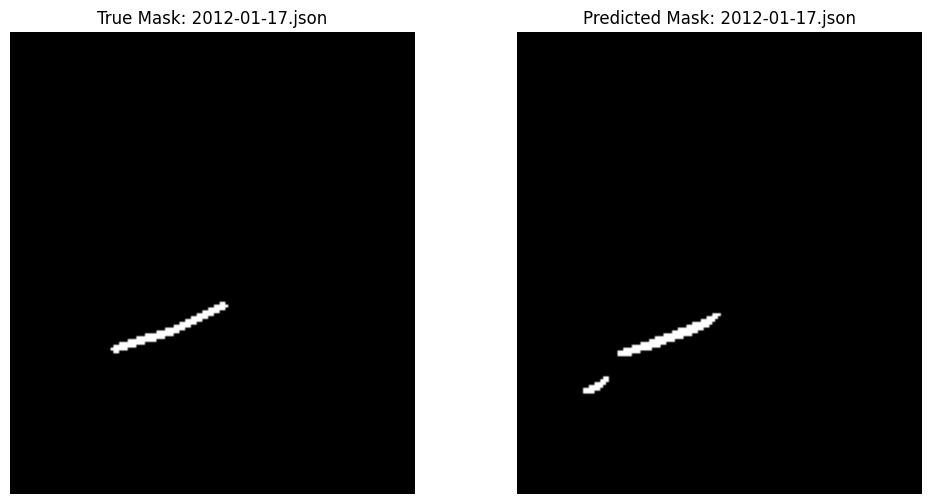

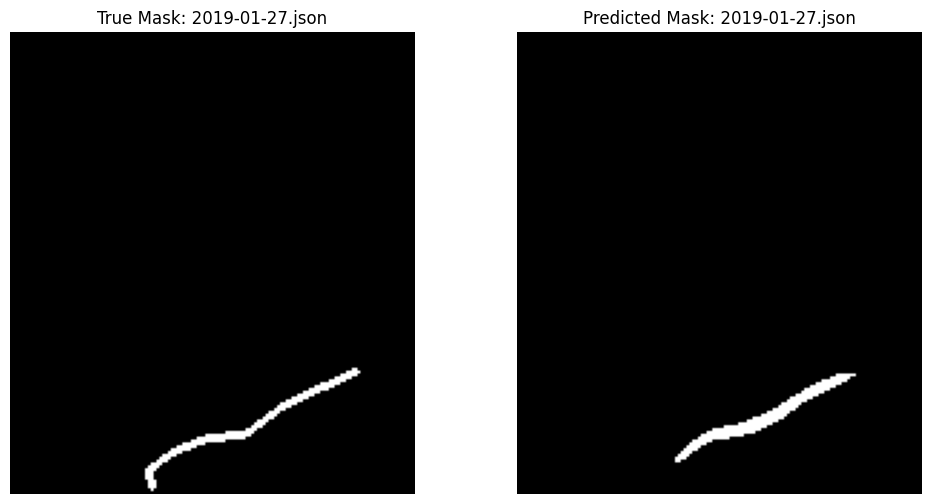

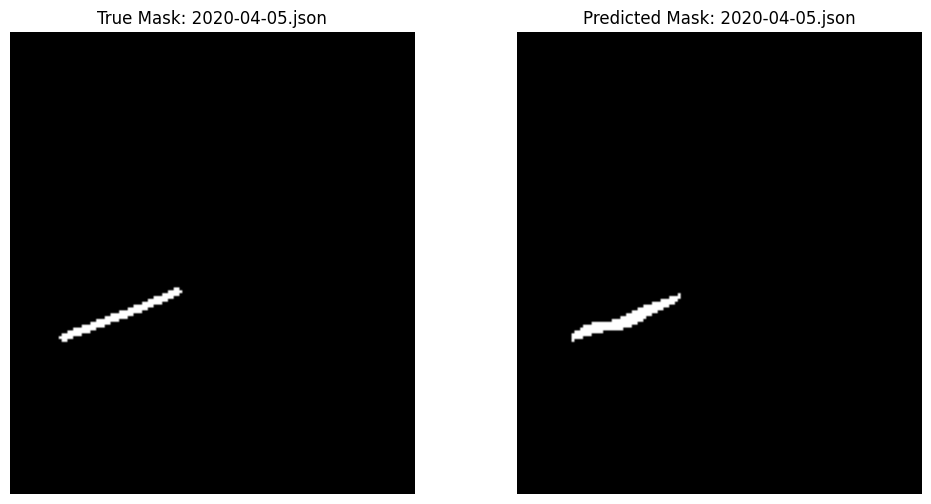

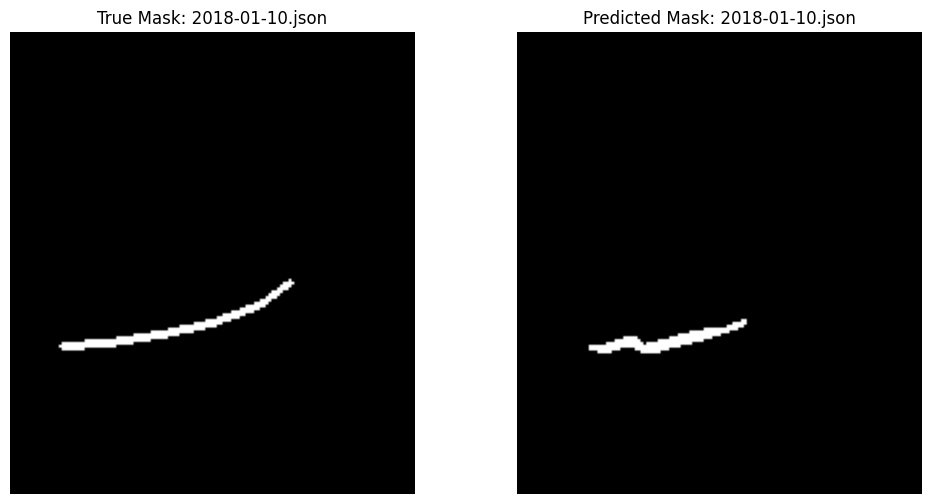

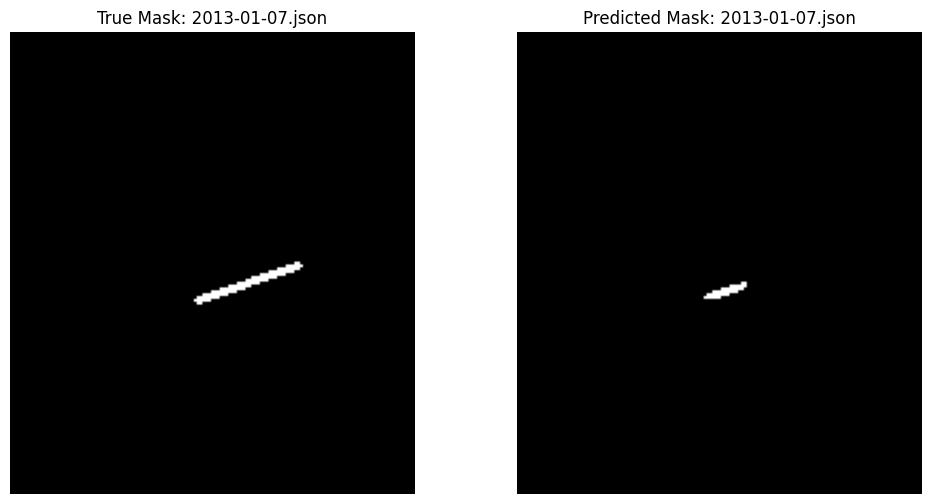

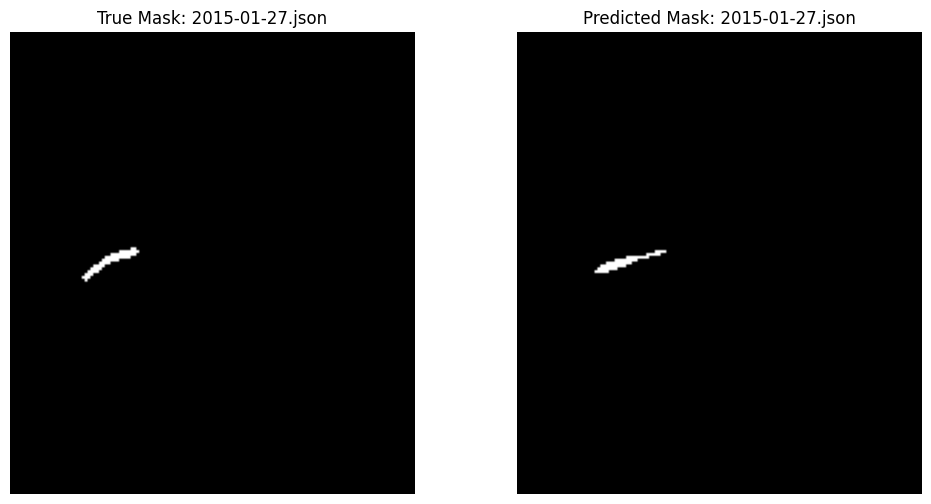

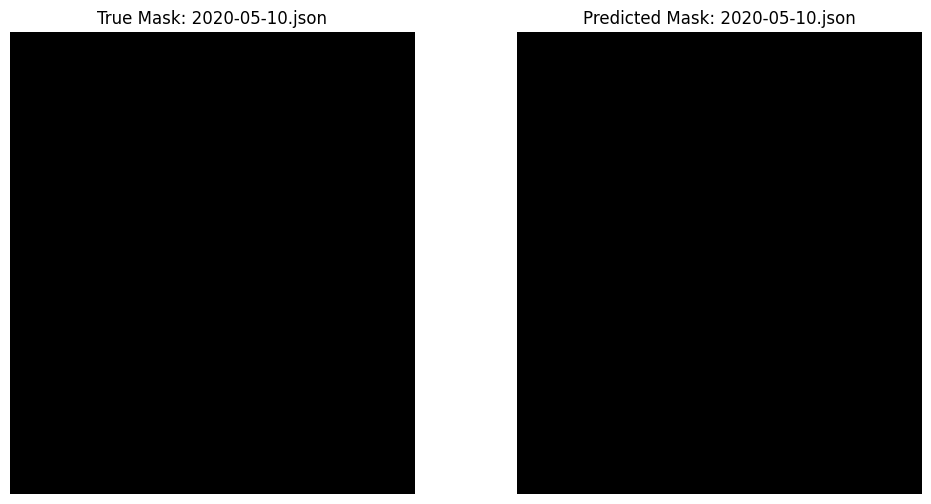

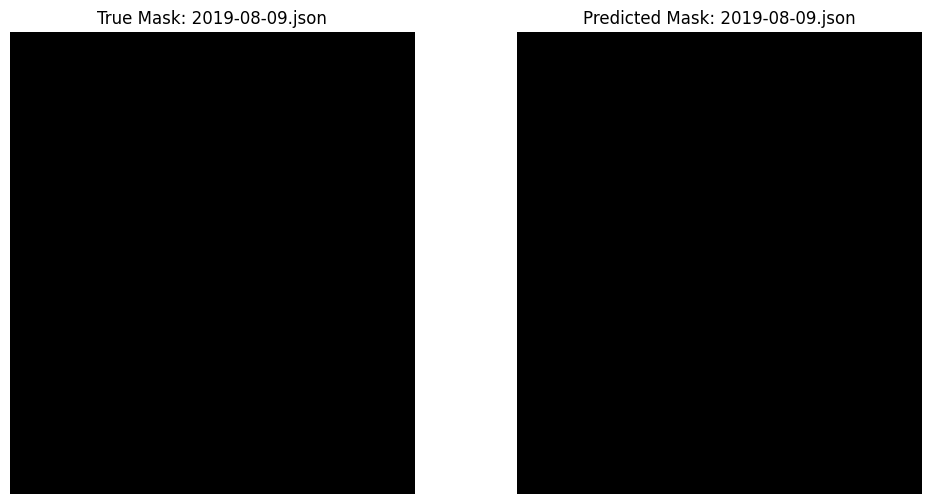

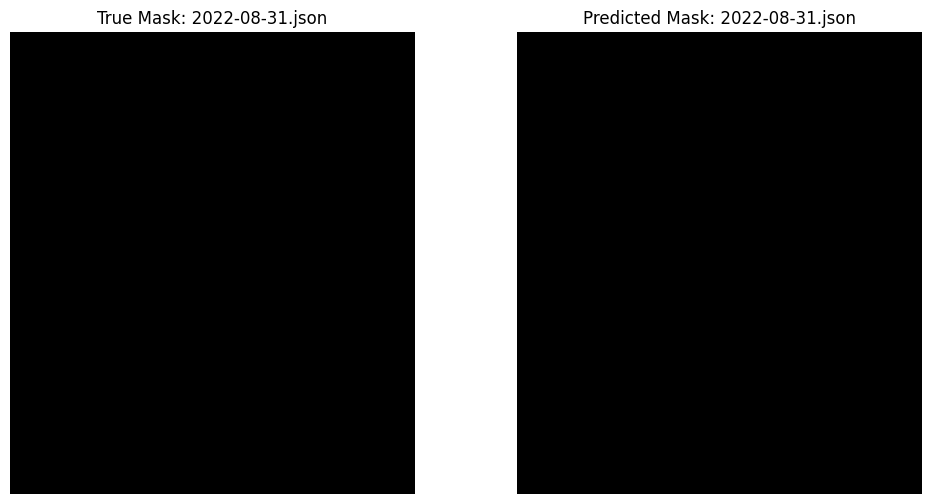

In [93]:
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

def visualize_comparison(filename, true_mask, predicted_mask):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(true_mask, cmap="gray")
    plt.title(f"True Mask: {filename}")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(predicted_mask, cmap="gray")
    plt.title(f"Predicted Mask: {filename}")
    plt.axis("off")

    plt.show()

for filename, true_mask, predicted_mask in zip(basenames_test, labels_test, predictions):
    visualize_comparison(filename, true_mask, predicted_mask)

## Step 12: Pixel-wise Segmentation Evaluation

> Evaluate the spatial map accuracy of predicted shear line binary mask using segmentation metrics.

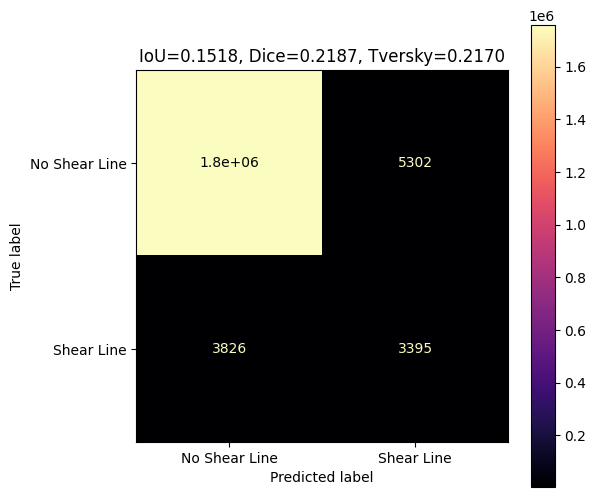

IoU Interpretation: Very Poor
Dice Interpretation: Poor
Tversky Interpretation: Poor


In [94]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def iou(y_true, y_pred):
    intersection = np.logical_and(y_true.astype(bool), y_pred.astype(bool)).sum()
    union = np.logical_or(y_true.astype(bool), y_pred.astype(bool)).sum()
    return intersection / union if union > 0 else 0.0

def dice(y_true, y_pred):
    intersection = np.logical_and(y_true.astype(bool), y_pred.astype(bool)).sum()
    denominator = y_true.astype(bool).sum() + y_pred.astype(bool).sum()
    return 2 * intersection / denominator if denominator > 0 else 0.0

def tversky(y_true, y_pred, alpha=0.7, beta=0.3):
    y_true_f = y_true.astype(bool)
    y_pred_f = y_pred.astype(bool)
    TP = np.logical_and(y_true_f, y_pred_f).sum()
    FP = np.logical_and(np.logical_not(y_true_f), y_pred_f).sum()
    FN = np.logical_and(y_true_f, np.logical_not(y_pred_f)).sum()
    denominator = TP + alpha * FP + beta * FN
    return TP / denominator if denominator > 0 else 0.0

ious = []
dices = []
tverskys = []
accuracies = []

for t_mask, p_mask in zip(labels_test, predictions):
    t_mask = t_mask.reshape(161, 141)
    p_mask = p_mask.reshape(161, 141)

    ious.append(iou(t_mask, p_mask))
    dices.append(dice(t_mask, p_mask))
    tverskys.append(tversky(t_mask, p_mask))
    accuracies.append(np.mean(t_mask.flatten() == p_mask.flatten()))

iou_score = np.mean(ious)
dice_score = np.mean(dices)
tversky_score = np.mean(tverskys)

true_all = np.concatenate([t.flatten() for t in labels_test])
pred_all = np.concatenate([p.flatten() for p in predictions])

cm = confusion_matrix(true_all, pred_all, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Shear Line", "Shear Line"])

fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap="magma", ax=ax)
plt.title(f"IoU={iou_score:.4f}, Dice={dice_score:.4f}, Tversky={tversky_score:.4f}")
plt.savefig(f"{ANALYSIS}/confusion_matrix_{training_timestamp}.png")
plt.show()

interpretations = {
    (0.90, 1.00): "Excellent",
    (0.75, 0.90): "Good",
    (0.50, 0.75): "Moderate",
    (0.20, 0.50): "Poor",
    (0.00, 0.20): "Very Poor"
}

for score_range, interpretation in interpretations.items():
    if score_range[0] <= iou_score <= score_range[1]:
        print(f"IoU Interpretation: {interpretation}")
        break

for score_range, interpretation in interpretations.items():
    if score_range[0] <= dice_score <= score_range[1]:
        print(f"Dice Interpretation: {interpretation}")
        break

for score_range, interpretation in interpretations.items():
    if score_range[0] <= tversky_score <= score_range[1]:
        print(f"Tversky Interpretation: {interpretation}")
        break

# Step 13: Duplicate Notebook  

**Note:** Manually save first before duplicating the notebook.

In [ ]:
VALIDATIONS = "validations"
os.makedirs(VALIDATIONS, exist_ok=True)

filename = "ShearLineCNN.ipynb"
with open(filename, "r", encoding="utf-8") as src:
    contents = src.read()
    checkpoint = f"{VALIDATIONS}/{filename}".replace(".ipynb", f"_{training_timestamp}.ipynb")
    with open(checkpoint, "w", encoding="utf-8") as dest:
        dest.write(contents)
        print(f"Checkpoint was created at '{checkpoint}'.")

> End of code.